In [143]:
import pandas as pd
import torch
import json
import os
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.ticker import ScalarFormatter
from sklearn.metrics import f1_score,accuracy_score,recall_score
import traceback



import warnings
warnings.filterwarnings('ignore')

In [2]:
from aif360.sklearn import metrics
from sklearn.metrics import confusion_matrix

In [3]:
# Try with Adult First

In [271]:
path = 'data/datasets/uci_adult/'
adult_df = pd.read_csv(path+'test.csv',header=None)
adult_df.columns = ['age', 'workclass', 'fnlwgt','education', 'education-num', 'marital-status',
           'occupation', 'relationship', 'race', 'sex', 'capital-gain',
           'capital-loss', 'hours-per-week', 'native-country','income']
adult_df['ground_truth'] = pd.Categorical(adult_df['income']).codes
adult_df.drop('income',axis=1,inplace=True)

In [272]:
for file in os.listdir(path+'preds/'):
    # check only text files
    if file.endswith('.json'):
        f = open(path+'preds/'+file)
        items = json.load(f)
        f.close()
        cname = file.split('.')[0]
        adult_df[cname]=items
    if file.endswith('.pt'):
        items = torch.load(path+'preds/'+file)
        cname = file.split('.')[0]
        adult_df[cname]=[int(i) for i in items.flatten().cpu().numpy()]

In [273]:
adult_df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,...,gsr_pred_FalsePositiveRateParity,gsr_pred_ErrorRateParity,caleq_pred_fnr,caleq_pred_fpr,caleq_pred_weighted,rocv_pred_statistical_parity,rocv_pred_average_odds,rocv_pred_equal_opportunity,DRO_pred,ARL_pred
0,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,...,0,0,0,0,0,0,0,0,0,0
1,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,...,0,0,0,0,0,0,0,0,0,0
2,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,...,0,0,0,0,0,0,0,0,0,0
3,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,...,1,1,1,1,1,1,1,1,1,1
4,18,?,103497.0,Some-college,10.0,Never-married,?,Own-child,White,Female,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,39,Private,215419.0,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,...,0,0,0,0,0,0,0,0,0,0
16277,64,?,321403.0,HS-grad,9.0,Widowed,?,Other-relative,Black,Male,...,0,0,0,0,0,0,0,0,0,0
16278,38,Private,374983.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,...,0,0,0,0,0,0,0,0,0,1
16279,44,Private,83891.0,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,...,1,1,1,1,1,1,1,1,1,0


In [274]:
def tprdiff(ground_truth, out_pred):
    out_m = out_pred.loc['Male']
    out_f = out_pred.loc['Female']
    ground_m = ground_truth.loc['Male']
    ground_f = ground_truth.loc['Female']
    tnm, fpm, fnm, tpm = confusion_matrix(ground_m, out_m).ravel()
    tnf, fpf, fnf, tpf = confusion_matrix(ground_f, out_f).ravel()
    TPD = (tpm/len(out_m)) - (tpf/len(out_f))
    FPD = (fpm/len(out_m)) - (fpf/len(out_f))
    FND = (fnm/len(out_m)) - (fnf/len(out_f))
    return TPD,FPD,FND

In [275]:
# ground_truth = adult_df['ground_truth']
# ground_truth.index = adult_df['sex']

# outputs = ['baseline_pred', 'adv_rew_pred', 'adv_deb_pred',
#        'lfr_pred', 'egr_pred_DemographicParity', 'egr_pred_EqualizedOdds',
#        'egr_pred_TruePositiveRateParity', 'egr_pred_FalsePositiveRateParity',
#        'egr_pred_ErrorRateParity', 'gsr_pred_DemographicParity',
#        'gsr_pred_EqualizedOdds', 'gsr_pred_TruePositiveRateParity',
#        'gsr_pred_FalsePositiveRateParity', 'gsr_pred_ErrorRateParity',
#        'caleq_pred_fnr', 'caleq_pred_fpr', 'caleq_pred_weighted',
#        'rocv_pred_statistical_parity', 'rocv_pred_average_odds',
#        'rocv_pred_equal_opportunity', 'DRO_pred', 'ARL_pred']

# for out in outputs: 

#     out_pred = adult_df[out]
#     out_pred.index = adult_df['sex']
    
#     try:
# #         print(out, 'statistical_parity_difference: ', metrics.statistical_parity_difference(out_pred,prot_attr='sex',priv_group='Male'))
#         TPD,FPD,FND = tprdiff(ground_truth, out_pred)
#         print(out, 'true_positive_rate_difference: ', TPD)
#         print(out, 'false_positive_rate_difference: ', FPD)
#         print(out, 'false_negative_rate_difference: ', FND)
# #         print(out, 'disparate_impact_ratio: ', metrics.disparate_impact_ratio(ground_truth,out_pred,prot_attr='sex',priv_group='Male'))
# #         print(out, 'equal_opportunity_difference: ', metrics.equal_opportunity_difference(ground_truth,out_pred,prot_attr='sex'))
# #         print(out, 'average_odds_difference: ', metrics.average_odds_difference(ground_truth,out_pred,prot_attr='sex'))
# # #         print(out, 'average_odds_error: ', metrics.average_odds_error(ground_truth,out_pred,prot_attr='sex'))
# #         print(out, 'kl_divergence: ', metrics.kl_divergence(ground_truth,out_pred,prot_attr='sex',priv_group='Male'))
# # #         print(out, 'conditional_demographic_disparity: ', metrics.conditional_demographic_disparity(ground_truth,out_pred,prot_attr='sex'))
# #         print(out, 'smoothed_edf: ', metrics.smoothed_edf(ground_truth,out_pred,prot_attr='sex'))
# #         print(out, 'df_bias_amplification: ', metrics.df_bias_amplification(ground_truth,out_pred,prot_attr='sex'))
# #         print(out, 'between_group_generalized_entropy_error: ', metrics.between_group_generalized_entropy_error(ground_truth,out_pred,prot_attr='sex',priv_group='Male'))
#     except:
#         pass
    

In [276]:
# Make groups

allm = ['baseline_pred', 'adv_rew_pred', 'adv_deb_pred',
       'lfr_pred', 'egr_pred_DemographicParity', 'egr_pred_EqualizedOdds',
       'egr_pred_TruePositiveRateParity', 'egr_pred_FalsePositiveRateParity',
       'egr_pred_ErrorRateParity', 'gsr_pred_DemographicParity',
       'gsr_pred_EqualizedOdds', 'gsr_pred_TruePositiveRateParity',
       'gsr_pred_FalsePositiveRateParity', 'gsr_pred_ErrorRateParity',
       'caleq_pred_fnr', 'caleq_pred_fpr', 'caleq_pred_weighted',
       'rocv_pred_statistical_parity', 'rocv_pred_average_odds',
       'rocv_pred_equal_opportunity', 'DRO_pred', 'ARL_pred']

metgroups = [

('statistical_parity_difference', ['baseline_pred', 'adv_rew_pred', 'adv_deb_pred',
       'lfr_pred', 'egr_pred_DemographicParity', 'gsr_pred_DemographicParity',
       'rocv_pred_statistical_parity', 'DRO_pred', 'ARL_pred']),

('true_positive_rate_difference', ['baseline_pred', 'adv_rew_pred', 'adv_deb_pred',
       'lfr_pred', 
       'egr_pred_TruePositiveRateParity', 'gsr_pred_TruePositiveRateParity', 'caleq_pred_weighted', 'DRO_pred', 'ARL_pred']),


('false_positive_rate_difference',['baseline_pred', 'adv_rew_pred', 'adv_deb_pred',
       'lfr_pred', 'egr_pred_FalsePositiveRateParity',
       'gsr_pred_FalsePositiveRateParity', 'caleq_pred_fpr', 'caleq_pred_weighted', 'DRO_pred', 'ARL_pred']),

('false_negative_rate_difference', ['baseline_pred', 'adv_rew_pred', 'adv_deb_pred','lfr_pred','caleq_pred_fnr', 'DRO_pred', 'ARL_pred']),

('disparate_impact_ratio', allm),

('equal_opportunity_difference', ['baseline_pred', 'adv_rew_pred', 'adv_deb_pred',
       'lfr_pred', 'rocv_pred_equal_opportunity', 'DRO_pred', 'ARL_pred']),

('average_odds_difference', ['baseline_pred', 'adv_rew_pred', 'adv_deb_pred',
       'lfr_pred',  'egr_pred_EqualizedOdds',
       'gsr_pred_EqualizedOdds', 'rocv_pred_average_odds','DRO_pred', 'ARL_pred']),

('kl_divergence',allm),

# ('smoothed_edf', allm),

# ('df_bias_amplification',allm),

('between_group_generalized_entropy_error',allm), #theil index
    
('accuracy', allm),
    
('f1_score', allm)

]
# (conditional_demographic_disparity, allm)




In [277]:
def getresultsdict(adult_df):
    ground_truth = adult_df['ground_truth']
    ground_truth.index = adult_df['sex']

    results = {}

    for item in metgroups:

        if item[0] == 'statistical_parity_difference':
            if 'Statistical Parity Difference' not in results:
                results['Statistical Parity Difference'] = {}
            for out in item[1]:
                try: 
                    out_pred = adult_df[out]
                    out_pred.index = adult_df['sex'] 
    #                 print(out, 'statistical_parity_difference: ', metrics.statistical_parity_difference(out_pred,prot_attr='sex',priv_group='Male'))
                    results['Statistical Parity Difference'][out] = metrics.statistical_parity_difference(out_pred,prot_attr='sex',priv_group='Male')
                except:
                    results['Statistical Parity Difference'][out] = None


        if item[0] == 'true_positive_rate_difference':
            if 'True Positive Rate Difference' not in results:
                results['True Positive Rate Difference'] = {}
            for out in item[1]:
                try: 
                    out_pred = adult_df[out]
                    out_pred.index = adult_df['sex'] 
                    TPD,FPD,FND = tprdiff(ground_truth, out_pred)
    #                 print(out, 'true_positive_rate_difference: ', TPD)
                    results['True Positive Rate Difference'][out] = TPD
                except:
                    results['True Positive Rate Difference'][out] = None

        if item[0] == 'false_positive_rate_difference':
            if 'False Positive Rate Difference' not in results:
                results['False Positive Rate Difference'] = {}
            for out in item[1]:
                try: 
                    out_pred = adult_df[out]
                    out_pred.index = adult_df['sex'] 
                    TPD,FPD,FND = tprdiff(ground_truth, out_pred) 
    #                 print(out, 'false_positive_rate_difference: ', FPD)
                    results['False Positive Rate Difference'][out] = FPD
                except:
                    results['False Positive Rate Difference'][out] = None

        if item[0] == 'false_negative_rate_difference':
            if 'False Negative Rate Difference' not in results:
                results['False Negative Rate Difference'] = {}
            for out in item[1]:
                try: 
                    out_pred = adult_df[out]
                    out_pred.index = adult_df['sex'] 
                    TPD,FPD,FND = tprdiff(ground_truth, out_pred)
    #                 print(out, 'false_negative_rate_difference: ', FND)
                    results['False Negative Rate Difference'][out] = FND
                except:
                    results['False Negative Rate Difference'][out] = None

        if item[0] == 'disparate_impact_ratio':
            if 'Disparate Impact Ratio' not in results:
                results['Disparate Impact Ratio'] = {}
            for out in item[1]:
                try: 
                    out_pred = adult_df[out]
                    out_pred.index = adult_df['sex']
    #                 print(out, 'disparate_impact_ratio: ', metrics.disparate_impact_ratio(ground_truth,out_pred,prot_attr='sex',priv_group='Male'))
                    results['Disparate Impact Ratio'][out] = metrics.disparate_impact_ratio(ground_truth,out_pred,prot_attr='sex',priv_group='Male')
                except:
                    results['Disparate Impact Ratio'][out] = None

        if item[0] == 'equal_opportunity_difference':
            if 'Equal Opportunity Difference' not in results:
                results['Equal Opportunity Difference'] = {}
            for out in item[1]:
                try: 
                    out_pred = adult_df[out]
                    out_pred.index = adult_df['sex']
    #                 print(out, 'equal_opportunity_difference: ', metrics.equal_opportunity_difference(ground_truth,out_pred,prot_attr='sex'))
                    results['Equal Opportunity Difference'][out] = metrics.equal_opportunity_difference(ground_truth,out_pred,prot_attr='sex')            
                except:
                    results['Equal Opportunity Difference'][out] = None

        if item[0] == 'average_odds_difference':
            if 'Average Odds Difference' not in results:
                results['Average Odds Difference'] = {}
            for out in item[1]:
                try: 
                    out_pred = adult_df[out]
                    out_pred.index = adult_df['sex']
    #                 print(out, 'average_odds_difference: ', metrics.average_odds_difference(ground_truth,out_pred,prot_attr='sex'))
                    results['Average Odds Difference'][out] = metrics.average_odds_difference(ground_truth,out_pred,prot_attr='sex')            
                except:
                    results['Average Odds Difference'][out] = None            

            if 'kl_divergence' not in results:
                results['KL Divergence'] = {}
            for out in item[1]:
                try: 
                    out_pred = adult_df[out]
                    out_pred.index = adult_df['sex']
    #                 print(out, 'kl_divergence: ', metrics.kl_divergence(ground_truth,out_pred,prot_attr='sex',priv_group='Male'))
                    results['KL Divergence'][out] = metrics.kl_divergence(ground_truth,out_pred,prot_attr='sex',priv_group='Male')       
                except:
                    results['KL Divergence'][out] = None

#         if item[0] == 'smoothed_edf':
#             if 'Smoothed Edf' not in results:
#                 results['Smoothed Edf'] = {}
#             for out in item[1]:
#                 try: 
#                     out_pred = adult_df[out]
#                     out_pred.index = adult_df['sex']
#     #                 print(out, 'smoothed_edf: ', metrics.smoothed_edf(ground_truth,out_pred,prot_attr='sex'))
#                     results['Smoothed Edf'][out] = metrics.smoothed_edf(ground_truth,out_pred,prot_attr='sex')    
#                 except:
#                     pass

#         if item[0] == 'df_bias_amplification':
#             if 'Df Bias Amplification' not in results:
#                 results['Df Bias Amplification'] = {}
#             for out in item[1]:
#                 try: 
#                     out_pred = adult_df[out]
#                     out_pred.index = adult_df['sex']
#     #                 print(out, 'df_bias_amplification: ', metrics.df_bias_amplification(ground_truth,out_pred,prot_attr='sex'))
#                     results['Df Bias Amplification'][out] = metrics.df_bias_amplification(ground_truth,out_pred,prot_attr='sex')
#                 except:
#                     pass

        if item[0] == 'between_group_generalized_entropy_error':
            if 'Between Group Generalized Entropy Error' not in results:
                results['Between Group Generalized Entropy Error'] = {}
            for out in item[1]:
                try: 
                    out_pred = adult_df[out]
                    out_pred.index = adult_df['sex']
    #                 print(out, 'between_group_generalized_entropy_error: ', metrics.between_group_generalized_entropy_error(ground_truth,out_pred,prot_attr='sex',priv_group='Male'))
                    results['Between Group Generalized Entropy Error'][out] = metrics.between_group_generalized_entropy_error(ground_truth,out_pred,prot_attr='sex',priv_group='Male')
                except:
                    results['Between Group Generalized Entropy Error'][out] = None
                
        if item[0] == 'accuracy':
            if 'Accuracy' not in results:
                results['Accuracy'] = {}
            for out in item[1]:
                try:
                    out_pred = adult_df[out]
                    out_pred.index = adult_df['sex']
                    results['Accuracy'][out] = accuracy_score(list(ground_truth), list(out_pred))
                except:
                    results['Accuracy'][out] = None
                
        if item[0] == 'f1_score':
            if 'F1 Score' not in results:
                results['F1 Score'] = {}
            for out in item[1]:
                try: 
                    out_pred = adult_df[out]
                    out_pred.index = adult_df['sex']
                    results['F1 Score'][out] = f1_score(list(ground_truth), list(out_pred))
                except:
                    results['F1 Score'][out] = None
    
    return results
            

In [278]:
namedic = {}
namedic['baseline_pred'] = 'Baseline LogReg (No Fairness Intervention)'
namedic['caleq_pred'] = 'Calibrated Equalized Odds'
namedic['rocv_pred'] = 'Reject Option Classifier'
namedic['adv_rew_pred'] = 'Sample Reweighting'
namedic['lfr_pred'] = 'Learned Fair Representation'
namedic['adv_deb_pred'] = 'Adversarial Debiasing'
namedic['egr_pred'] = 'Exponentiated Gradient Reduction'
namedic['gsr_pred'] = 'Gridsearch Reduction'
namedic['DRO_pred'] = 'Distributed Robust Optimization'
namedic['ARL_pred'] = 'Adversarially Reweighted Learning'
def algnames(name):
    return namedic[name]

In [279]:
# 2 line plots per metric - synthetic
# histograms for case studies 

def get_df(results, percentage, version):

    yeslist = ['baseline_pred', 'caleq_pred_fnr', 'caleq_pred_fpr', 'caleq_pred_weighted',
           'rocv_pred_statistical_parity', 'rocv_pred_average_odds',
           'rocv_pred_equal_opportunity'] 

    midlist = ['adv_rew_pred', 'lfr_pred', 'adv_deb_pred',
           'egr_pred_DemographicParity', 'egr_pred_EqualizedOdds',
           'egr_pred_TruePositiveRateParity', 'egr_pred_FalsePositiveRateParity',
           'egr_pred_ErrorRateParity', 'gsr_pred_DemographicParity',
           'gsr_pred_EqualizedOdds', 'gsr_pred_TruePositiveRateParity',
           'gsr_pred_FalsePositiveRateParity', 'gsr_pred_ErrorRateParity'] 

    nolist = ['DRO_pred', 'ARL_pred'] 

    DF_list = []

    for metric in results:
        algset = {}
        for alg in results[metric]:
            entry = {}
            entry['metric'] = metric
            if len(alg.split('_pred'))>0:
                if alg.split('_pred')[0]+'_pred' not in algset:
                    algset[alg.split('_pred')[0]+'_pred']=[]
                if results[metric][alg]:    
                    algset[alg.split('_pred')[0]+'_pred'].append(results[metric][alg])
                entry['algorithm'] = algnames(alg.split('_pred')[0]+'_pred')
                entry['value'] = np.mean(algset[alg.split('_pred')[0]+'_pred'])
            else:
                entry['algorithm'] = algnames(alg)
                entry['value'] = results[metric][alg]
            if alg in yeslist:
                entry['Needs Attributes'] = 'Both during Training and Testing'
            if alg in midlist:
                entry['Needs Attributes'] = 'During Training only'
            if alg in nolist:
                entry['Needs Attributes'] = 'Does not require protected attributes'
            DF_list.append(entry)

    resultsdf = pd.DataFrame(DF_list)
    resultsdf = resultsdf.drop_duplicates(subset=['metric', 'algorithm'], keep='last')
    
    resultsdf['percentage'] = percentage
    resultsdf['version'] = version

    df_temps = []
    for group, df_group in resultsdf.groupby('metric'):
        df_group['pct'] = 100 * (1 - df_group.iloc[0].value / df_group.value)
        df_group['diff'] = df_group.value - df_group.iloc[0].value
        df_temps.append(df_group)
        
    return pd.concat(df_temps)


In [280]:
def get_stability(tdf):
    tdf = groupsizedf[groupsizedf['metric']=='Average Odds Difference']
    tdf = tdf.groupby(['algorithm','percentage']).agg('std').reset_index().fillna(0)
    tdf = tdf.groupby(['algorithm']).agg("mean").reset_index()
    tdf = tdf[['algorithm','value']]
    return dict(zip(tdf['algorithm'],tdf['value']))

In [302]:
sorter = ['Baseline LogReg (No Fairness Intervention)',
 'Calibrated Equalized Odds',
 'Reject Option Classifier',
 'Sample Reweighting',
 'Learned Fair Representation',
 'Adversarial Debiasing',
 'Exponentiated Gradient Reduction',
 'Gridsearch Reduction',
 'Distributed Robust Optimization',
 'Adversarially Reweighted Learning']

In [303]:
results = getresultsdict(adult_df)
df_temps = get_df(results,0,0)
df_temps.sort_values(by="algorithm", key=lambda column: column.map(lambda e: sorter.index(e)), inplace=True)

In [304]:
df_temps

,metric,algorithm,value,Needs Attributes,percentage,version,pct,diff
104,Accuracy,Baseline LogReg (No Fairness Intervention),0.799582,Both during Training and Testing,0,0,0.000000,0.000000
73,KL Divergence,Baseline LogReg (No Fairness Intervention),0.014199,Both during Training and Testing,0,0,0.000000,0.000000
18,False Positive Rate Difference,Baseline LogReg (No Fairness Intervention),-0.002163,Both during Training and Testing,0,0,0.000000,0.000000
0,Statistical Parity Difference,Baseline LogReg (No Fairness Intervention),-0.043274,Both during Training and Testing,0,0,0.000000,0.000000
35,Disparate Impact Ratio,Baseline LogReg (No Fairness Intervention),0.572377,Both during Training and Testing,0,0,0.000000,0.000000
...,...,...,...,...,...,...,...,...
125,Accuracy,Adversarially Reweighted Learning,0.849825,Does not require protected attributes,0,0,5.912113,0.050243
27,False Positive Rate Difference,Adversarially Reweighted Learning,0.032294,Does not require protected attributes,0,0,106.696332,0.034456
72,Average Odds Difference,Adversarially Reweighted Learning,-0.213692,Does not require protected attributes,0,0,-65.457176,0.139876
147,F1 Score,Adversarially Reweighted Learning,0.622160,Does not require protected attributes,0,0,38.996466,0.242621


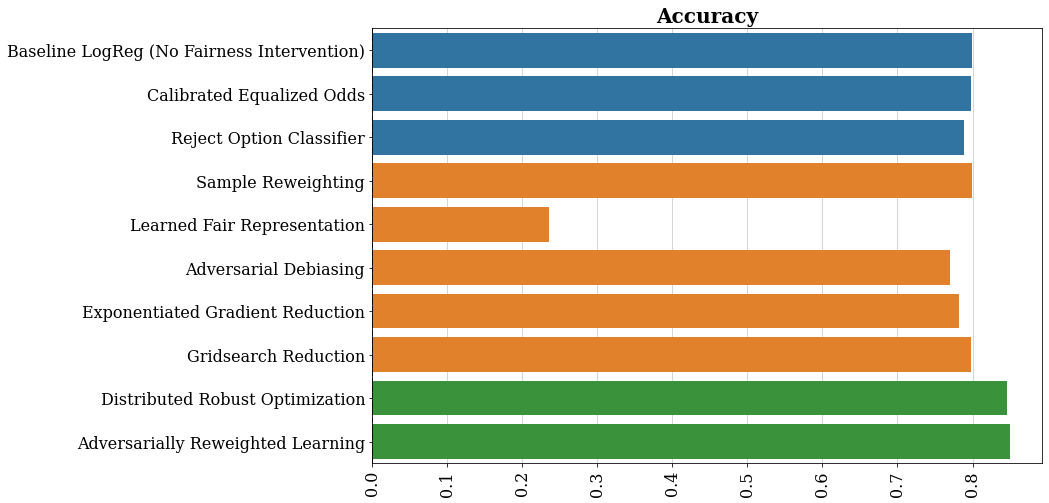

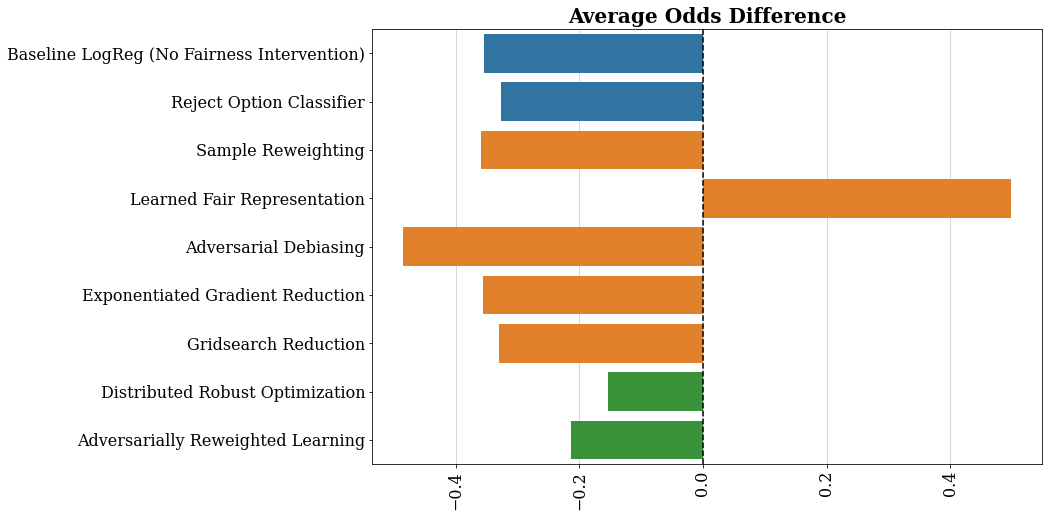

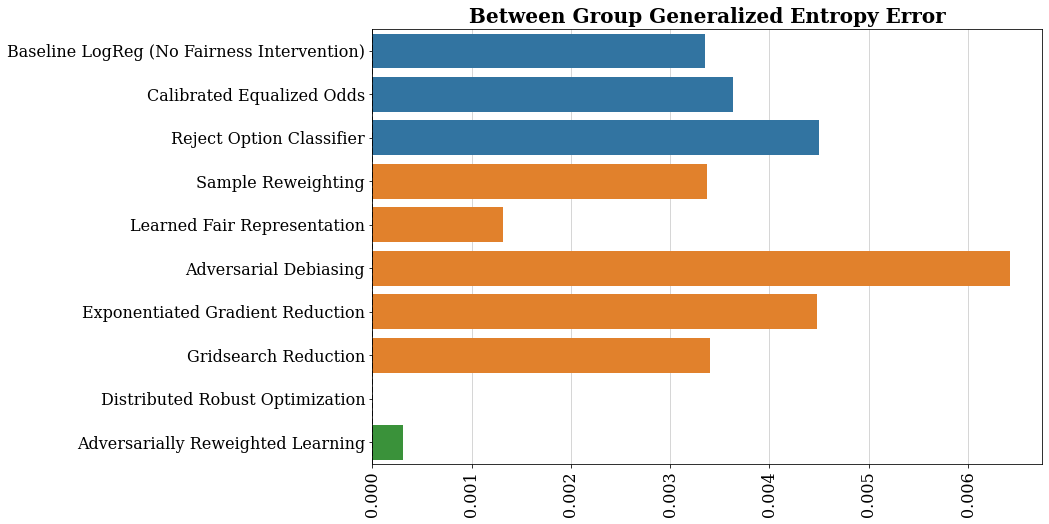

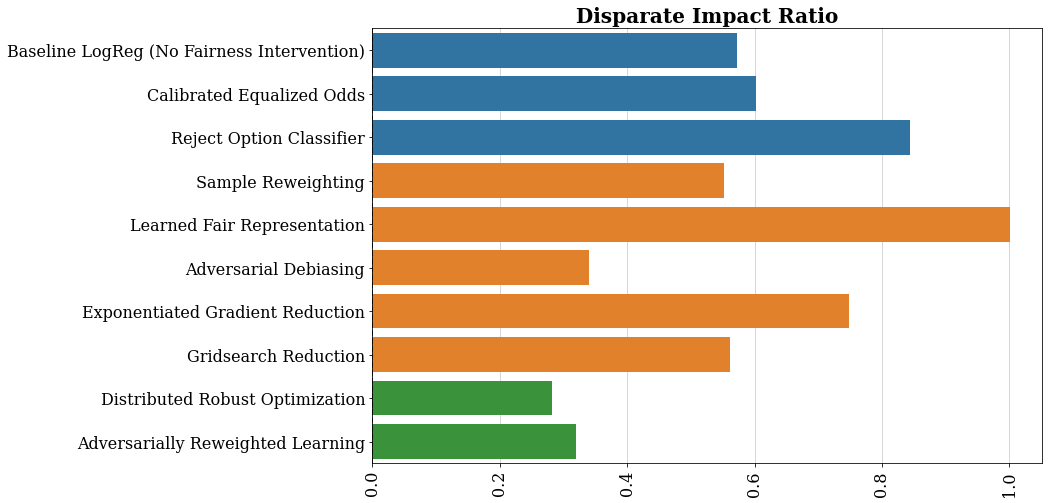

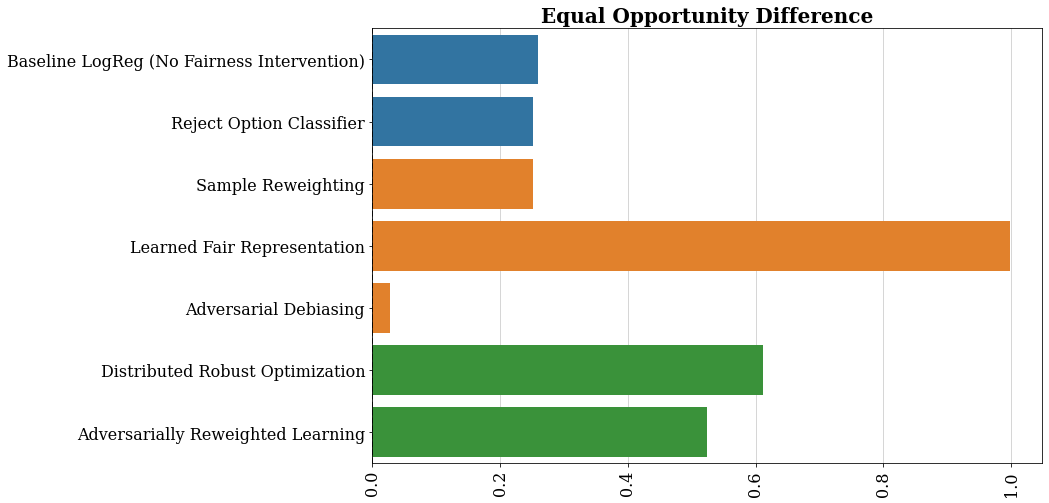

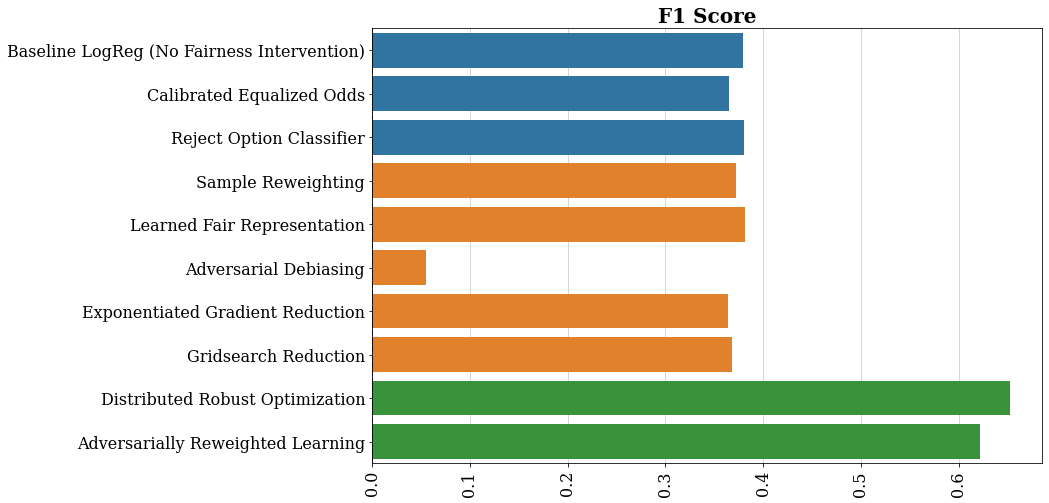

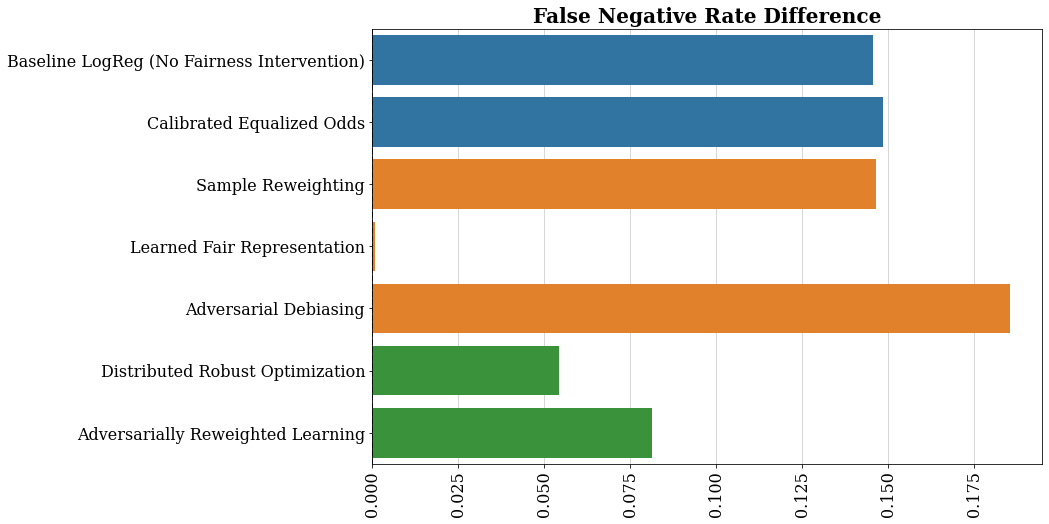

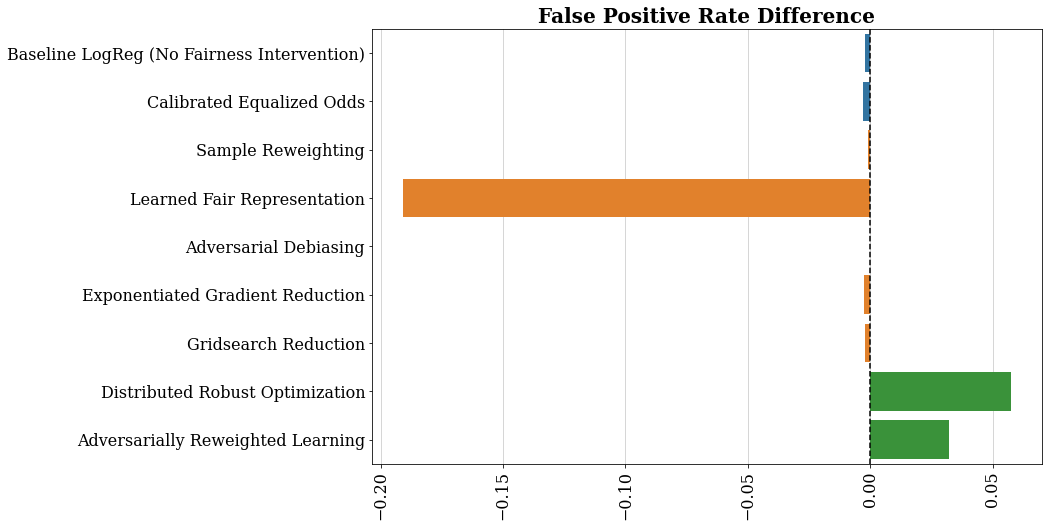

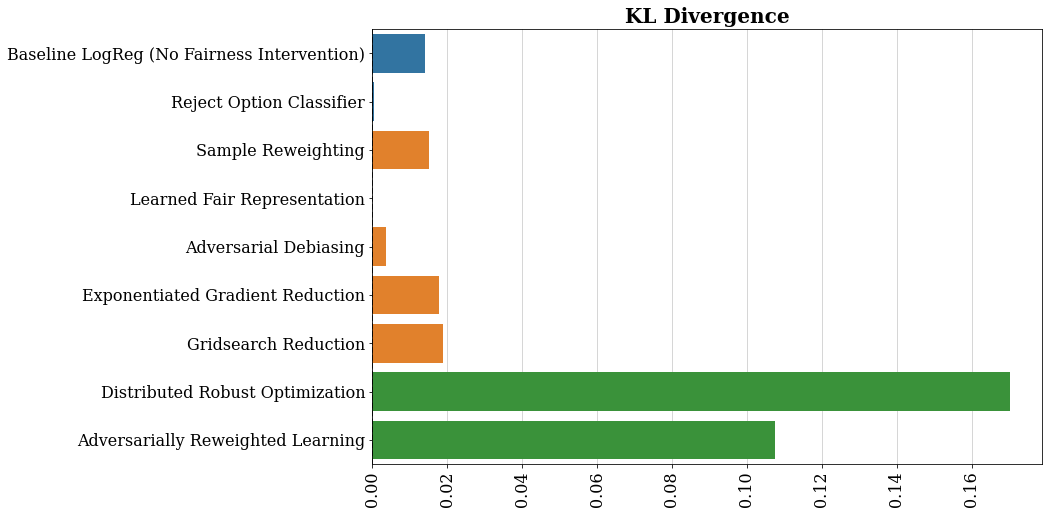

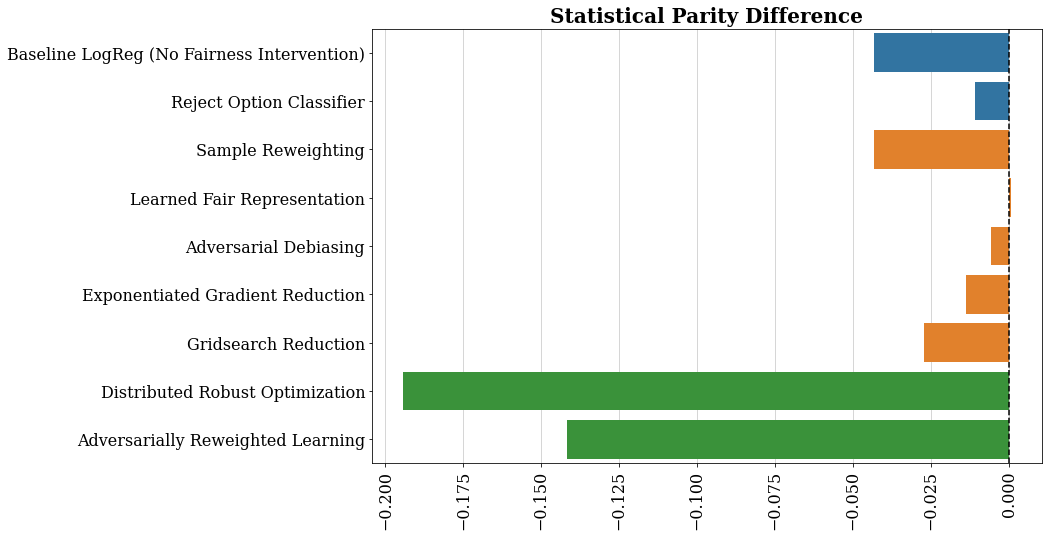

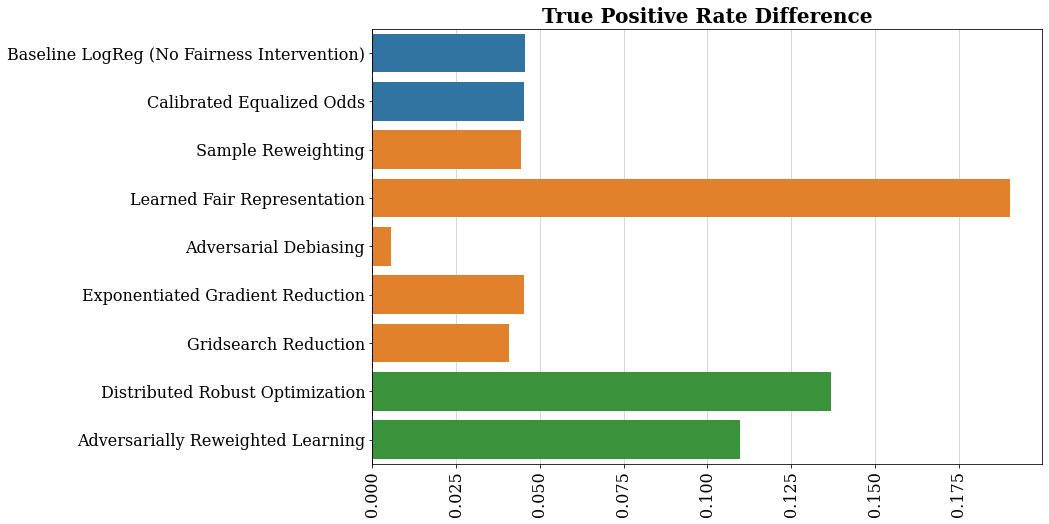

In [315]:
mpl.rcParams['figure.figsize'] = (12, 8)
plt.rcParams["font.family"] = 'DejaVu Serif'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42


gdic = {}

for group, df_group in df_temps.groupby('metric'):
    hue_order = ['Both during Training and Testing', 'During Training only', 'Does not require protected attributes']
    ax = sns.barplot(data=df_group, y='algorithm', x='value', hue='Needs Attributes',dodge=False,hue_order=hue_order)
    
    plt.title(group,fontsize=20,weight='bold')
    
    ax.xaxis.grid(True,which='both')
    ax.yaxis.grid(False,which='both')


    ax.set_facecolor('white')
    ax.tick_params(axis='y', which='both',labelsize=16)
    ax.tick_params(axis='x', which='both',labelsize=16)
    ax.get_legend().remove()
    ax.set_axisbelow(True)
    plt.xlabel(None)
    plt.ylabel(None)
#     plt.xlabel(group)
    plt.xticks(rotation = 90) 
#     plt.xscale("symlog")
    plt.gca().xaxis.set_major_formatter(ScalarFormatter())
    plt.axvline(x = 0, color = 'black', linestyle = '--')
    plt.savefig('Plots/casestudy__'+group+'.pdf', pad_inches = 0,bbox_inches = "tight")

    plt.show()

# Synthetic Data

## When Group Size is changed

In [168]:
reslist = []
_percentages =  [[0.1],[0.2],[0.3],[0.4],[0.5],[0.6],[0.7],[0.8],[0.9]]
for percentages in _percentages:
    for version in np.arange(10):
        dirc = path+('synthetic/female_groupsize{}_version{}/'.format(percentages[0],version))
        adult_df = pd.read_csv(dirc+'test.csv',header=None)
        adult_df.columns = ['age', 'workclass', 'fnlwgt','education', 'education-num', 'marital-status',
                   'occupation', 'relationship', 'race', 'sex', 'capital-gain',
                   'capital-loss', 'hours-per-week', 'native-country','income']
        adult_df['ground_truth'] = pd.Categorical(adult_df['income']).codes
        adult_df.drop('income',axis=1,inplace=True)
        for file in os.listdir(path+'preds/'):
            # check only text files
            if file.endswith('.json'):
                f = open(dirc+'preds/'+file)
                items = json.load(f)
                f.close()
                cname = file.split('.')[0]
                adult_df[cname]=items
            if file.endswith('.pt'):
                items = torch.load(dirc+'preds/'+file)
                cname = file.split('.')[0]
                adult_df[cname]=[int(i) for i in items.flatten().cpu().numpy()]
                
        results = getresultsdict(adult_df)
        reslist.append(get_df(results,percentages[0],version))

In [169]:
groupsizedf = pd.concat(reslist)

In [170]:
# mpl.rcParams['figure.figsize'] = (10, 6)
# for group,df_group in groupsizedf.groupby('metric'):
#     df_group = df_group.reset_index()
#     sns.lineplot(data=df_group, x="percentage", y="pct", hue="algorithm", style="needs attributes", markers=True, dashes=True)
#     plt.yscale("symlog")
#     plt.title(group)
#     plt.legend(loc=(1.05, 0))
#     plt.xlabel("Percentage of women in training set")
#     plt.ylabel('Percentage change of metric from baseline')
#     plt.gca().yaxis.set_major_formatter(ScalarFormatter())
#     plt.show()

In [171]:
def conv(x):
    return 1/(1+x)

In [216]:

#     yeslist = ['baseline_pred', 'caleq_pred_fnr', 'caleq_pred_fpr', 'caleq_pred_weighted',
#            'rocv_pred_statistical_parity', 'rocv_pred_average_odds',
#            'rocv_pred_equal_opportunity'] 

#     midlist = ['adv_rew_pred', 'lfr_pred', 'adv_deb_pred',
#            'egr_pred_DemographicParity', 'egr_pred_EqualizedOdds',
#            'egr_pred_TruePositiveRateParity', 'egr_pred_FalsePositiveRateParity',
#            'egr_pred_ErrorRateParity', 'gsr_pred_DemographicParity',
#            'gsr_pred_EqualizedOdds', 'gsr_pred_TruePositiveRateParity',
#            'gsr_pred_FalsePositiveRateParity', 'gsr_pred_ErrorRateParity'] 

#     nolist = ['DRO_pred', 'ARL_pred'] 

mstyle = {'Baseline LogReg (No Fairness Intervention)': 'o', #
          'Calibrated Equalized Odds': (4, 1, 90), 
          'Reject Option Classifier': (6, 1, 0), 
          
          'Sample Reweighting': '<', 
          'Learned Fair Representation': '>', 
          'Adversarial Debiasing': '^', 
          'Exponentiated Gradient Reduction': 'v', 
          'Gridsearch Reduction': 'd', 
          
          'Distributed Robust Optimization': 'P', 
          'Adversarially Reweighted Learning': 'X'
         }

# [',', '.', 'o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X']

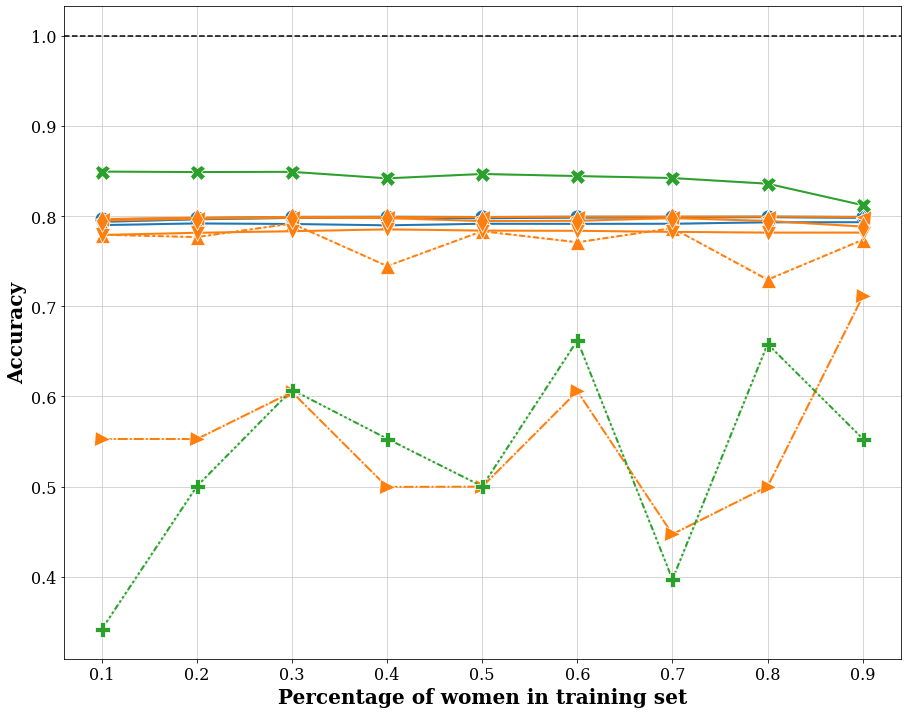

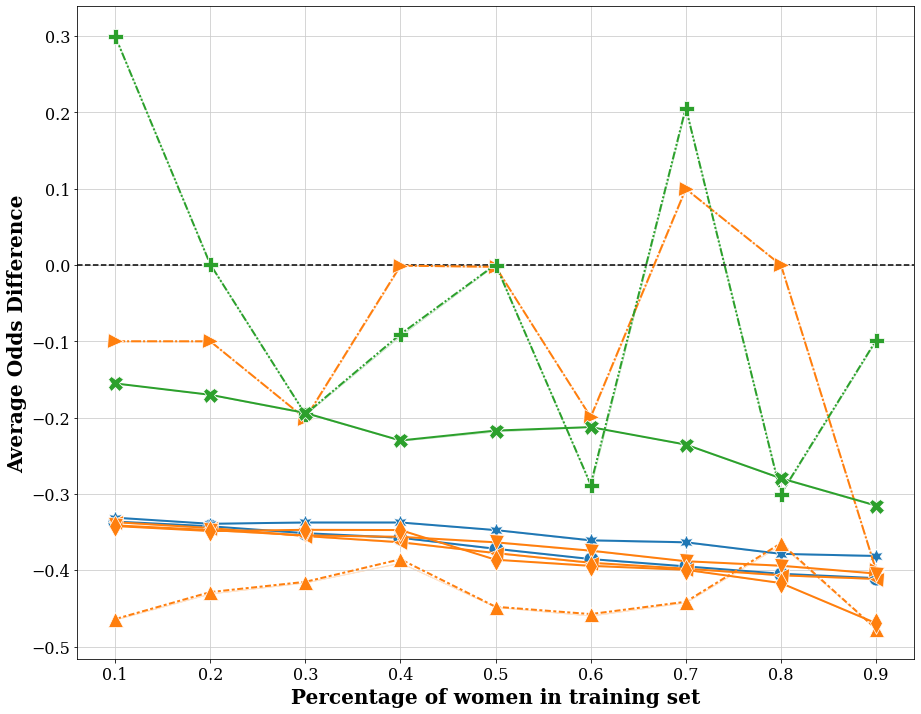

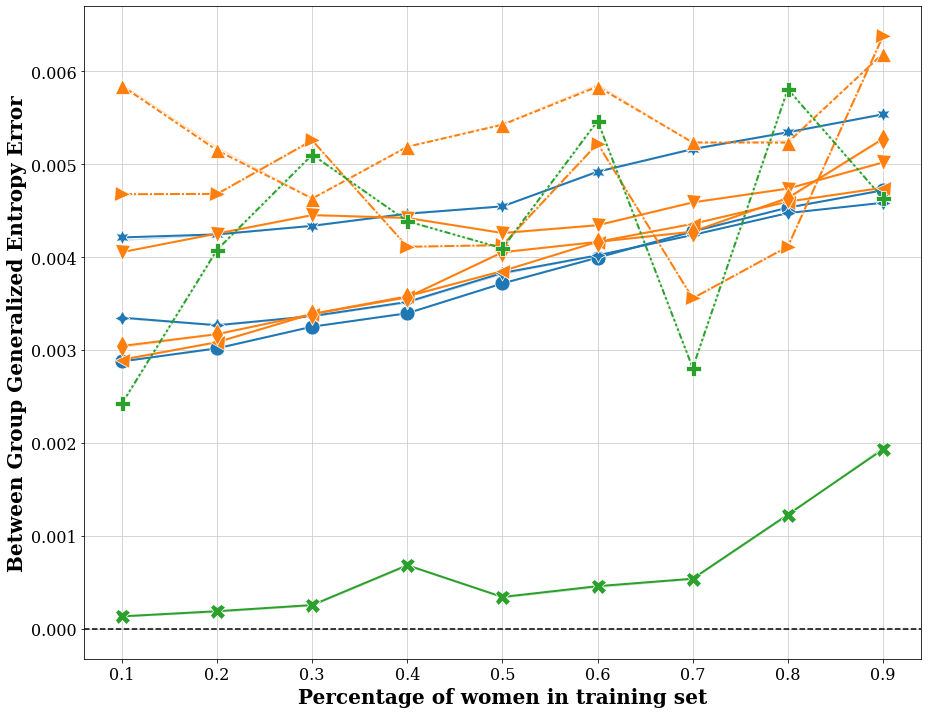

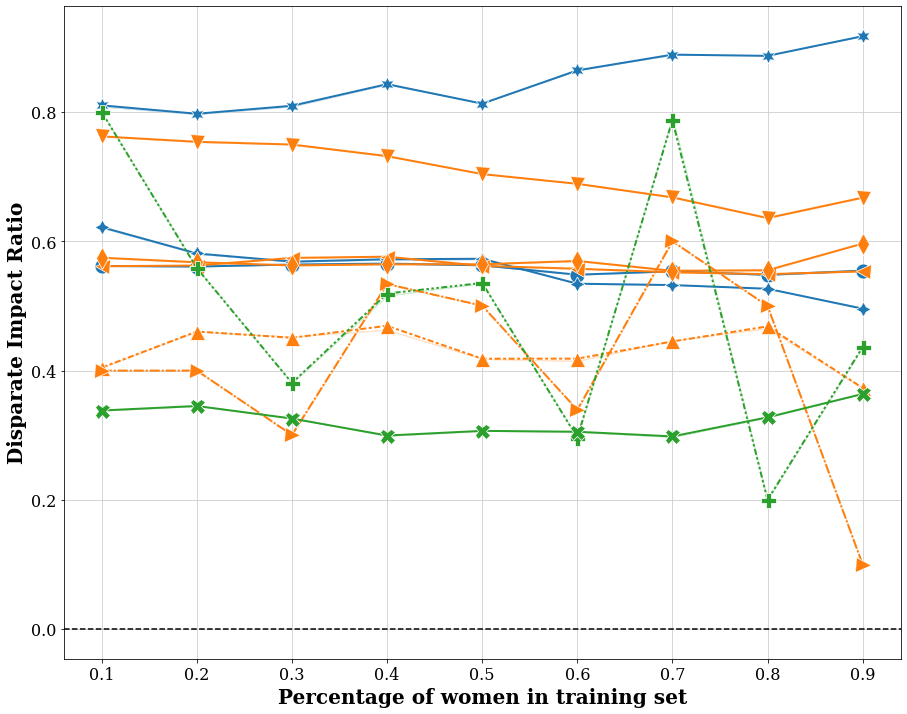

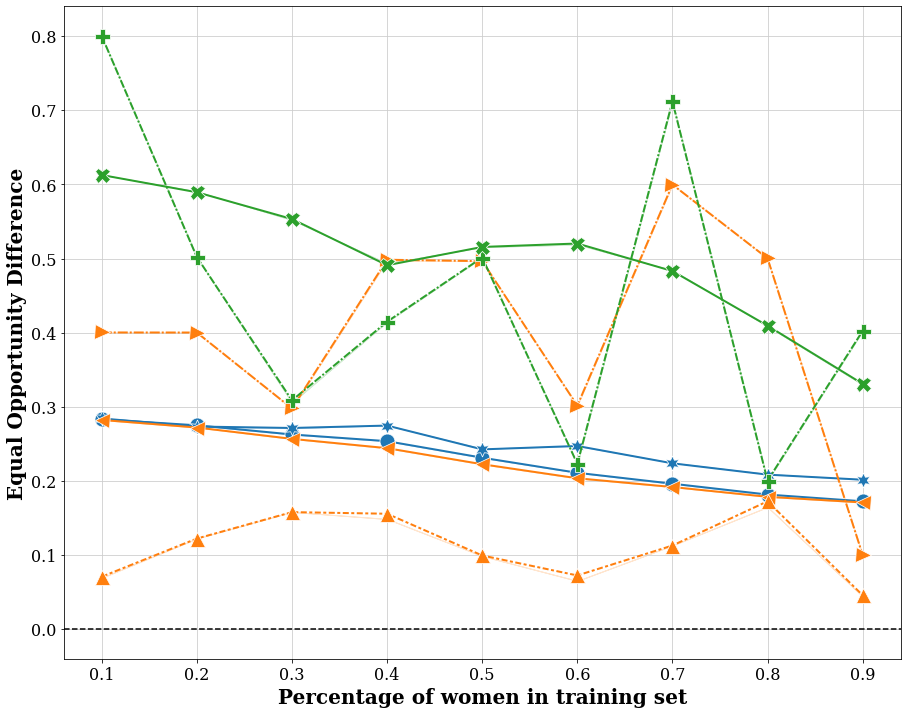

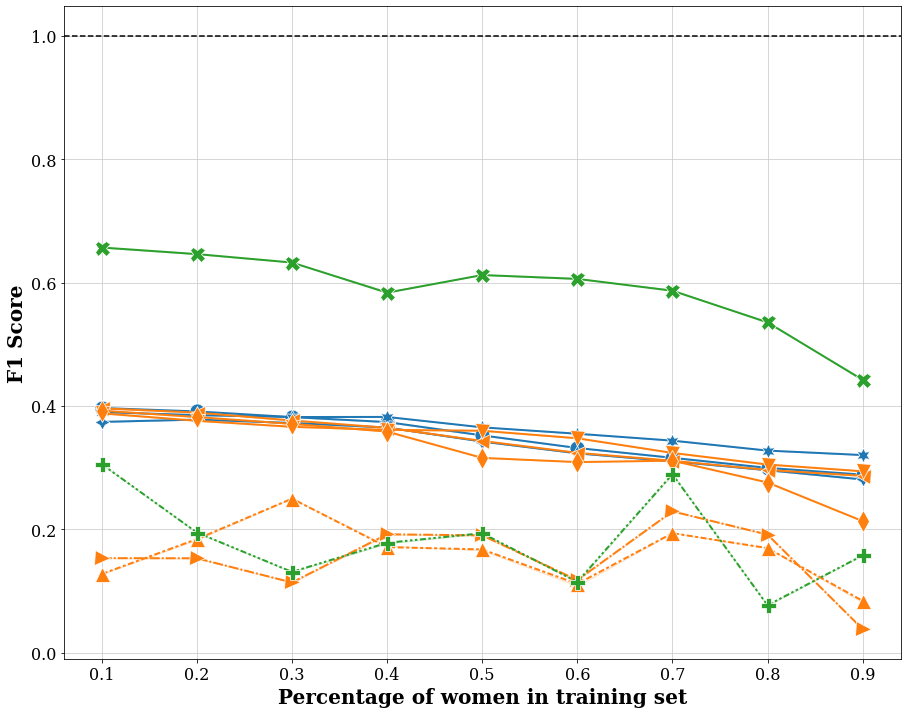

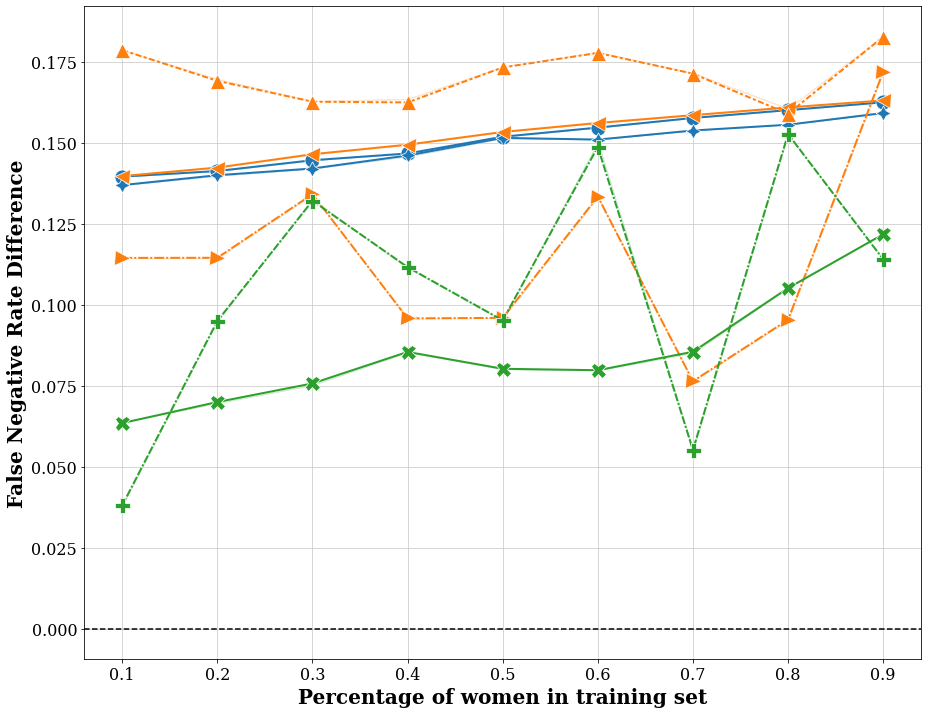

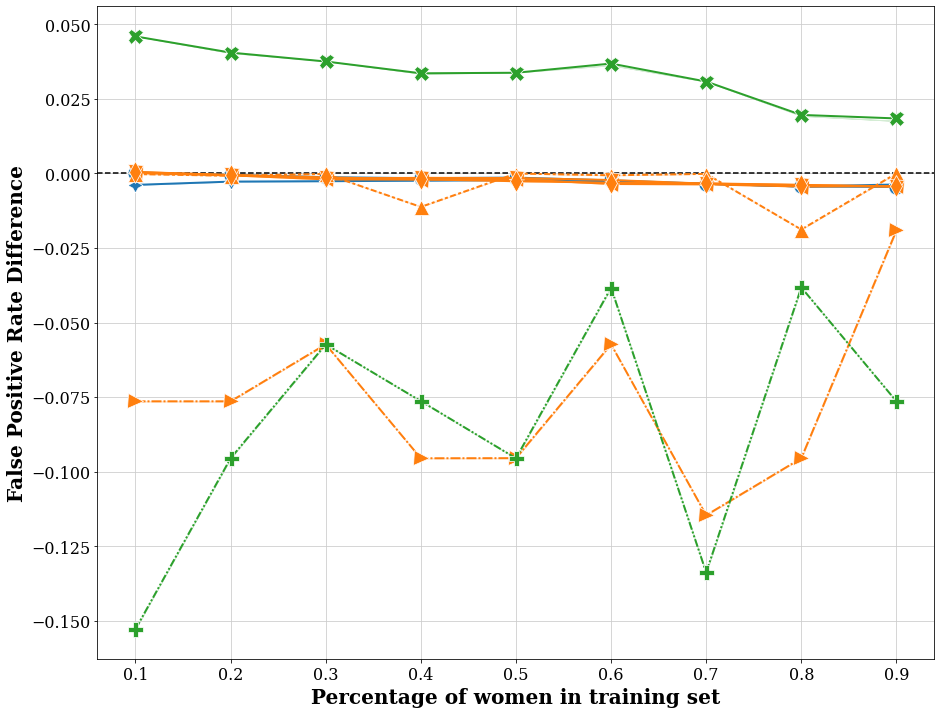

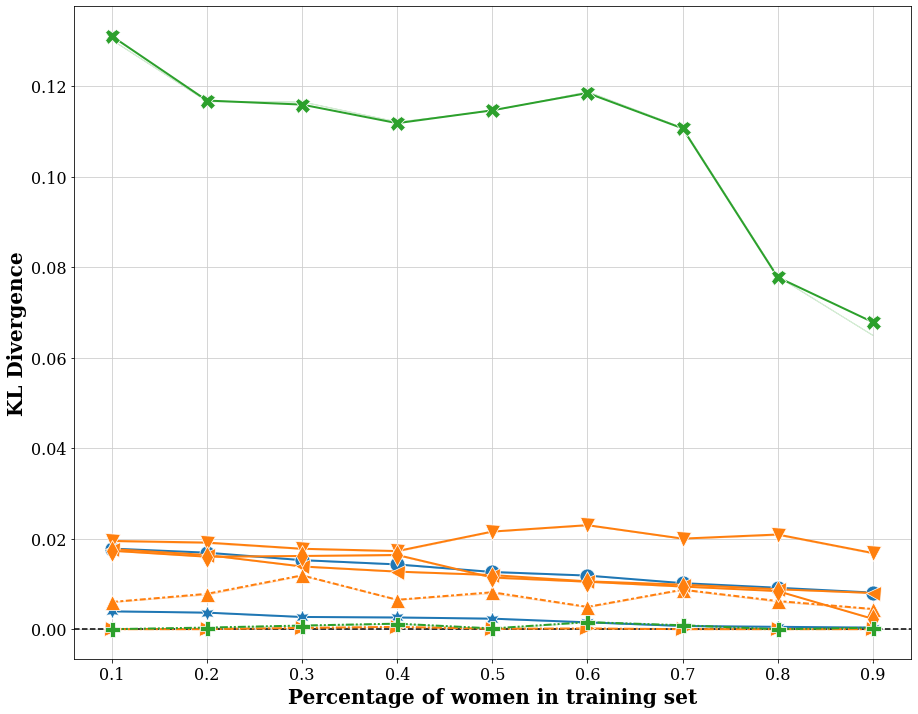

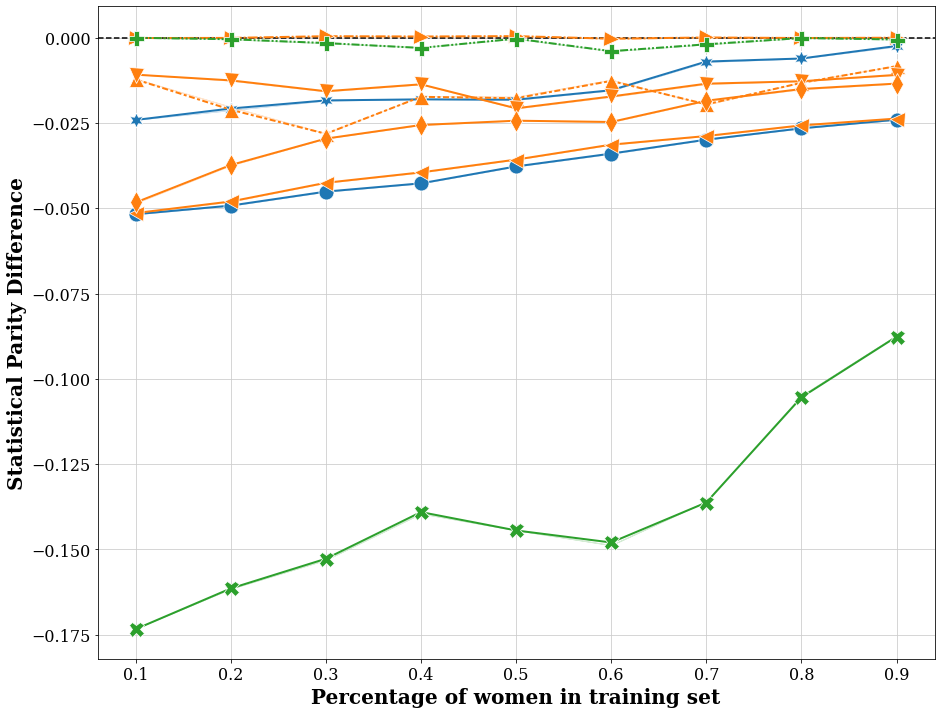

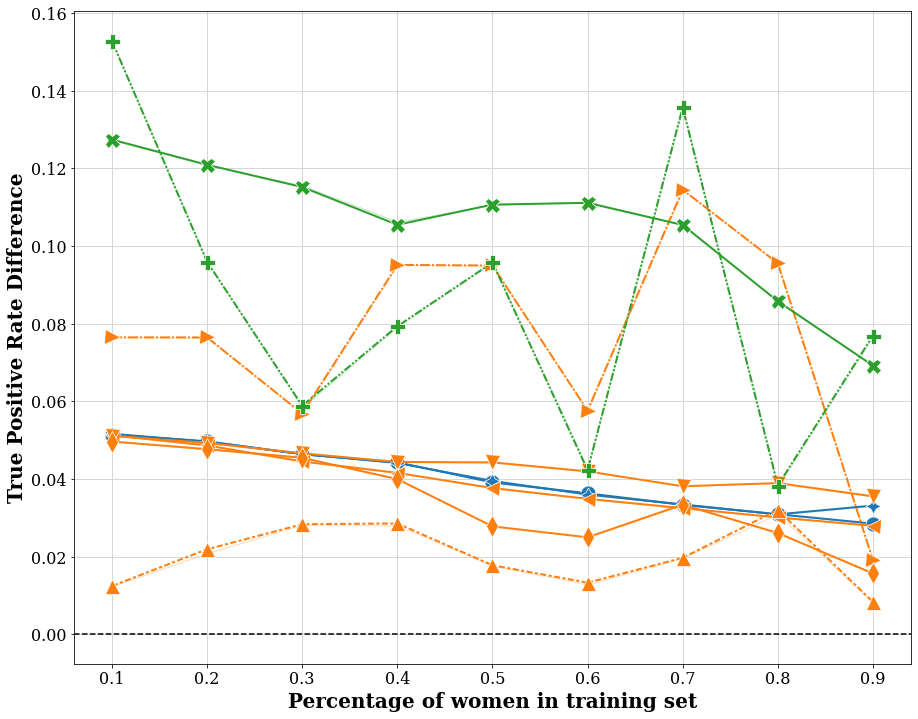

In [257]:
mpl.rcParams['figure.figsize'] = (15, 12)
plt.rcParams["font.family"] = 'DejaVu Serif'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42
algs = set(groupsizedf['algorithm'])
ax = None

for group,df_group in groupsizedf.groupby('metric'):
    df_group = df_group.reset_index(drop=True)
    sdic = get_stability(df_group)
    inc = []
    for alg in sdic:
        if conv(sdic[alg])>.92:
            inc.append(alg)
    for a in algs:
        if a not in sdic:
            inc.append(a)
#     for s in sdic:
#         print(s,sdic[s],conv(sdic[s]))
    dash_list = sns._core.unique_dashes(df_group['algorithm'].unique().size+1)
    style = {key:value for key,value in zip(df_group['algorithm'].unique(), dash_list[1:])}
    for i in inc:
        style[i]=''
        
    if group in ['F1 Score', 'Accuracy']:
        plt.axhline(y=1,linestyle ='--', color='black')
    else:
        plt.axhline(y=0,linestyle ='--', color = 'black')

            
    ax = sns.lineplot(data=df_group, x="percentage", y="value", hue="Needs Attributes", style="algorithm", markers=mstyle, dashes=style, ci = 0, linewidth = 2, markersize=15) #dashes=style
#     plt.title(group)
    plt.legend(loc=(1.05, 0))
    plt.xlabel("Percentage of women in training set",fontsize=20,weight='bold')
    plt.ylabel(group,fontsize=20,weight='bold')
    
    ax.xaxis.grid(True,which='both')
    ax.yaxis.grid(True,which='both')


    ax.set_facecolor('white')
    ax.tick_params(axis='y', which='both',labelsize=16)
    ax.tick_params(axis='x', which='both',labelsize=16)
    ax.get_legend().remove()

    plt.gca().yaxis.set_major_formatter(ScalarFormatter())
    plt.savefig('Plots/synthetic_groupsize_'+group+'.pdf', pad_inches = 0,bbox_inches = "tight")
    plt.show()



## When base rate is changed

In [178]:
reslist = []
_percentages =  [[0.33,0.1],[0.33,0.2],[0.33,0.3],[0.33,0.4],[0.33,0.5],[0.33,0.6],[0.33,0.7],[0.33,0.8],[0.33,0.9]]
for percentages in _percentages:
    for version in np.arange(10):
        dirc = path+('synthetic/female_baserate{}_version{}/'.format(percentages[1],version))
        adult_df = pd.read_csv(dirc+'test.csv',header=None)
        adult_df.columns = ['age', 'workclass', 'fnlwgt','education', 'education-num', 'marital-status',
                   'occupation', 'relationship', 'race', 'sex', 'capital-gain',
                   'capital-loss', 'hours-per-week', 'native-country','income']
        adult_df['ground_truth'] = pd.Categorical(adult_df['income']).codes
        adult_df.drop('income',axis=1,inplace=True)
        for file in os.listdir(path+'preds/'):
            # check only text files
            if file.endswith('.json'):
                try:
                    f = open(dirc+'preds/'+file)
                    items = json.load(f)
                    f.close()
                    cname = file.split('.')[0]
                    adult_df[cname]=items
                except:
                    pass
            if file.endswith('.pt'):
                try:
                    items = torch.load(dirc+'preds/'+file)
                    cname = file.split('.')[0]
                    adult_df[cname]=[int(i) for i in items.flatten().cpu().numpy()]
                except:
                    pass
                
        results = getresultsdict(adult_df)
        reslist.append(get_df(results,percentages[1],version))
        

In [179]:
baseratedf = pd.concat(reslist)

In [180]:
# for group,df_group in baseratedf.groupby('metric'):
#     df_group = df_group.reset_index()
#     sns.lineplot(data=df_group, x="percentage", y="pct", hue="algorithm", style="needs attributes", markers=True, dashes=True)
#     plt.yscale("symlog")
#     plt.title(group)
#     plt.legend(loc=(1.05, 0))
#     plt.xlabel("Base rate of women in training set")
#     plt.ylabel('Percentage change of metric from baseline')
#     plt.gca().yaxis.set_major_formatter(ScalarFormatter())
#     plt.show()

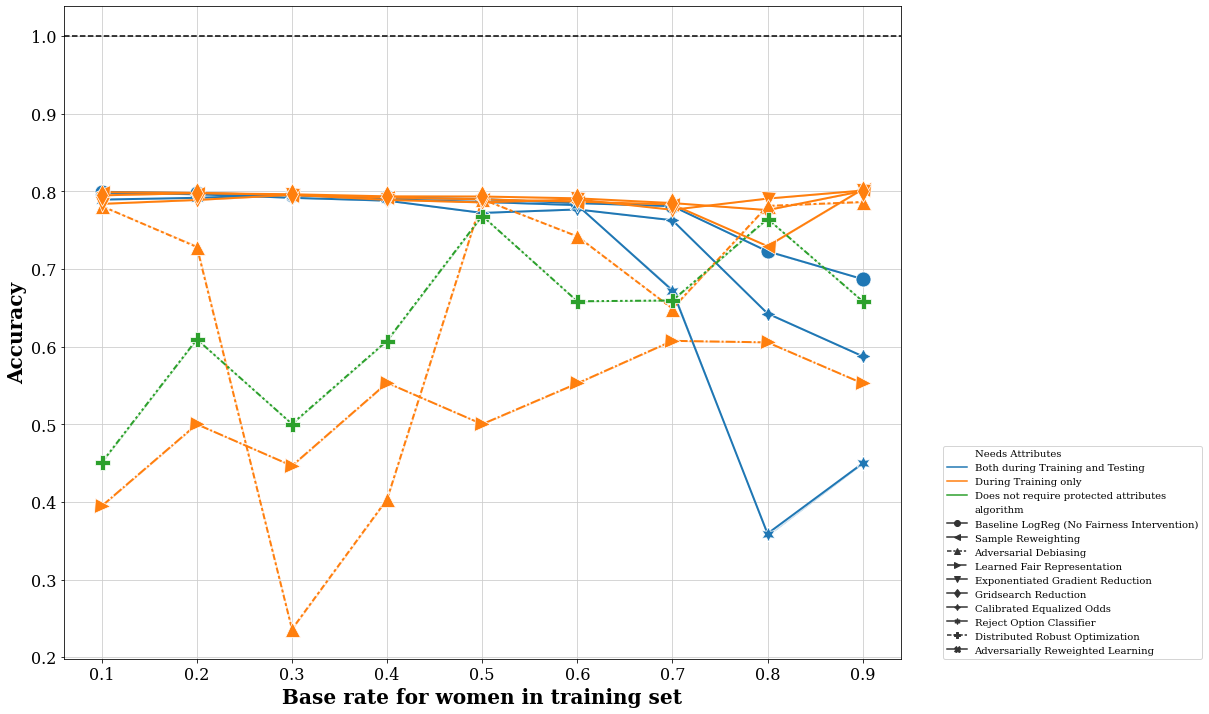

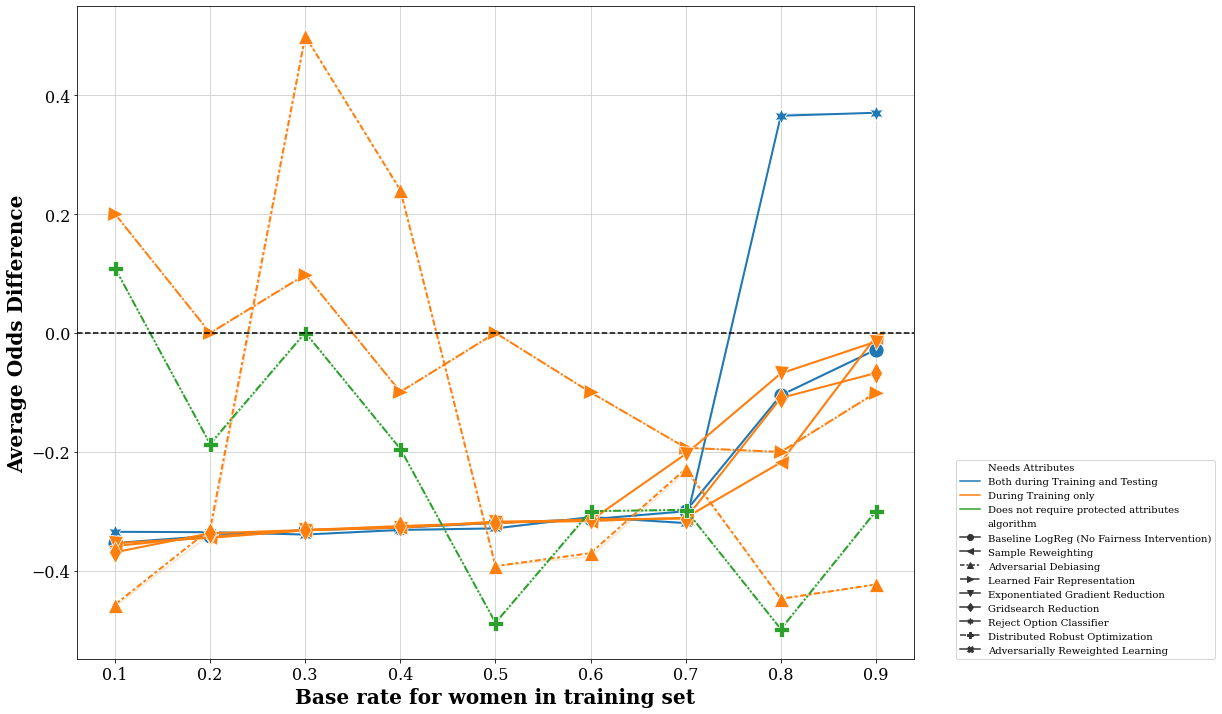

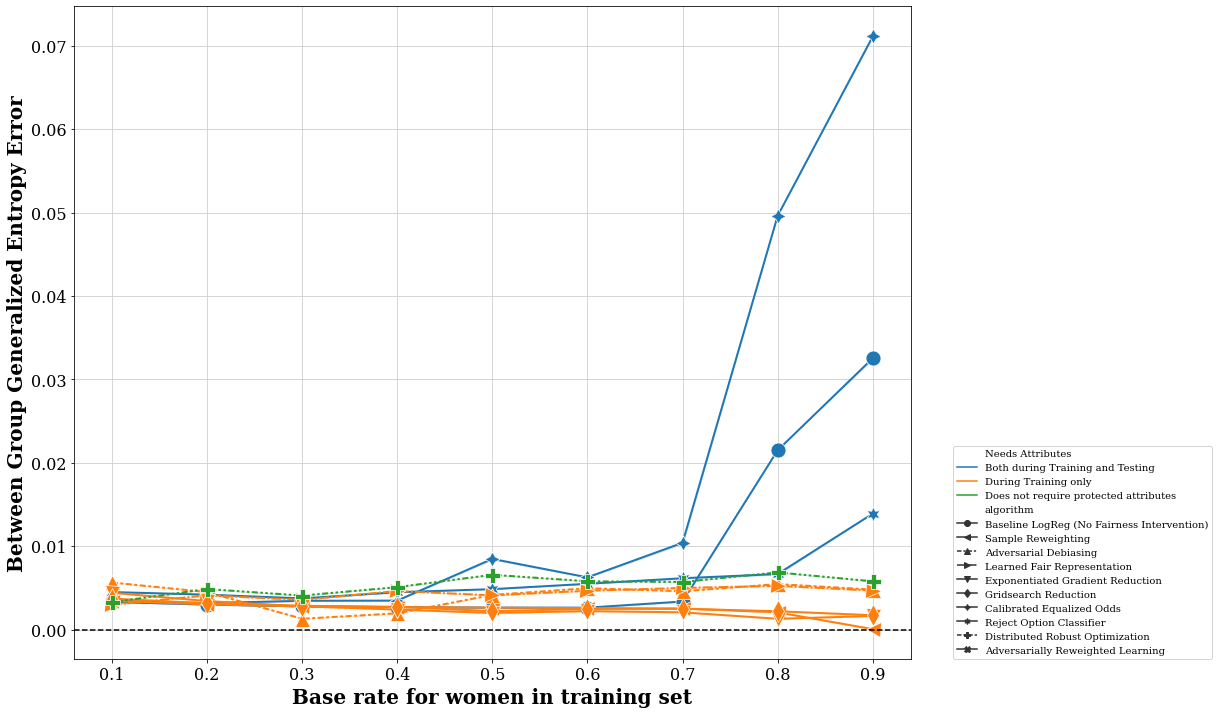

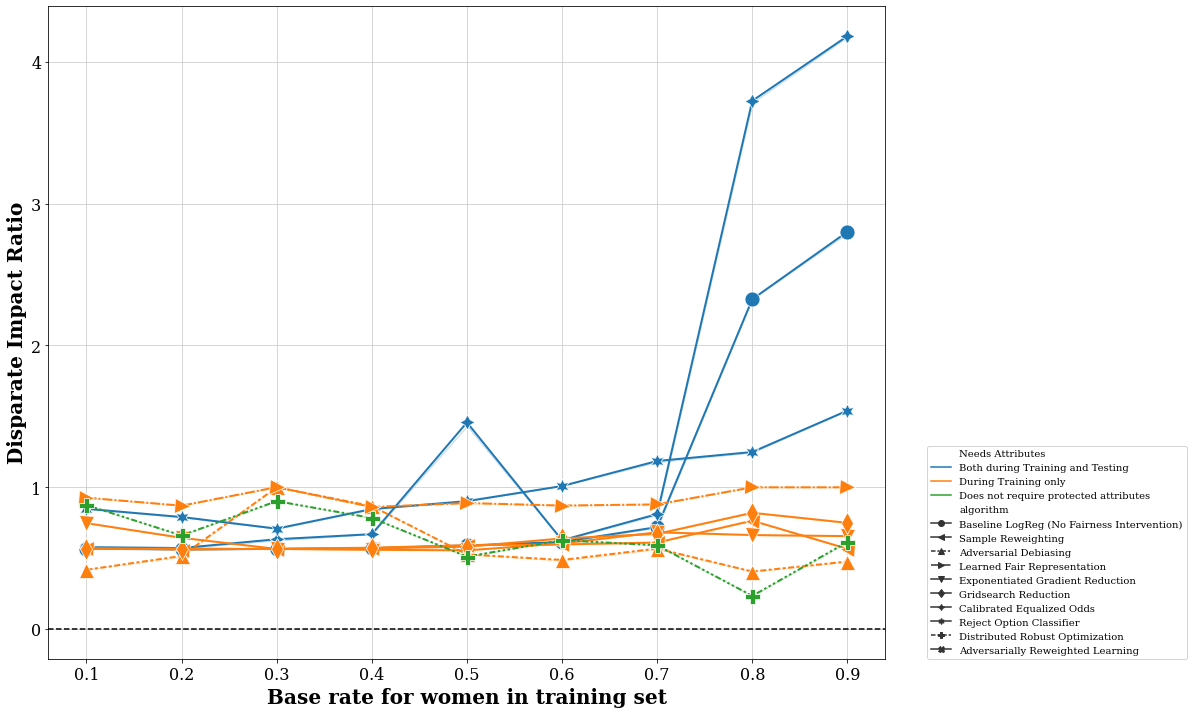

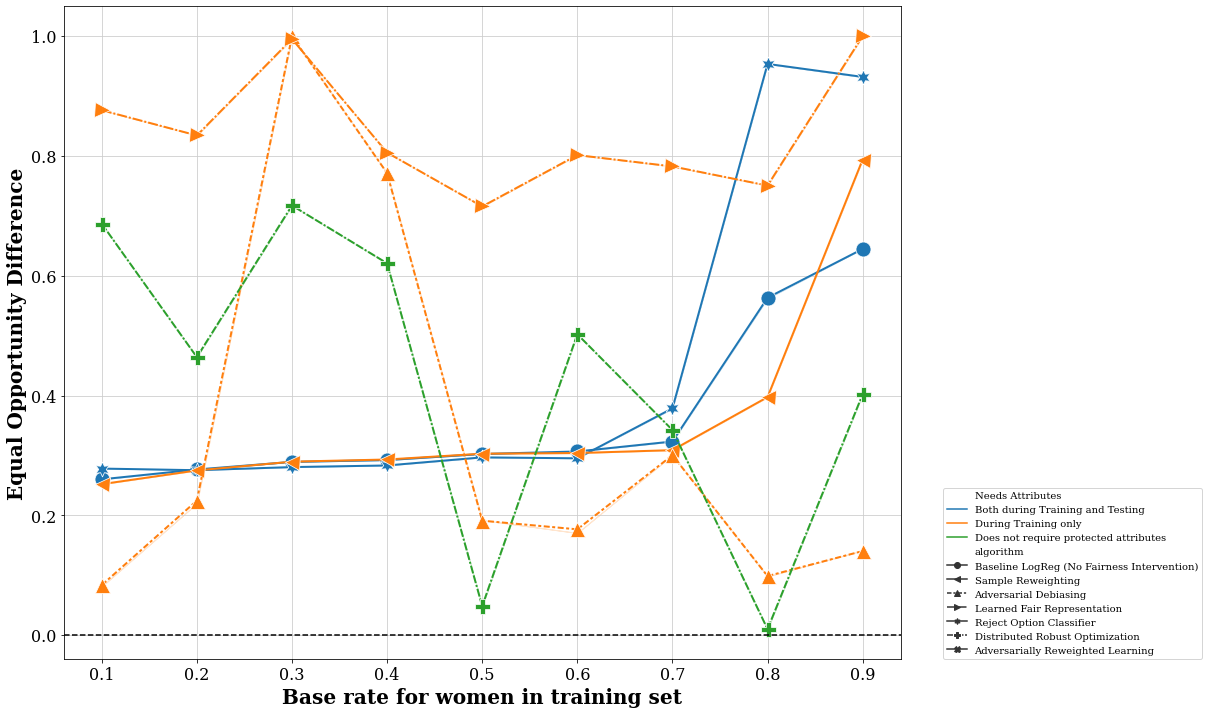

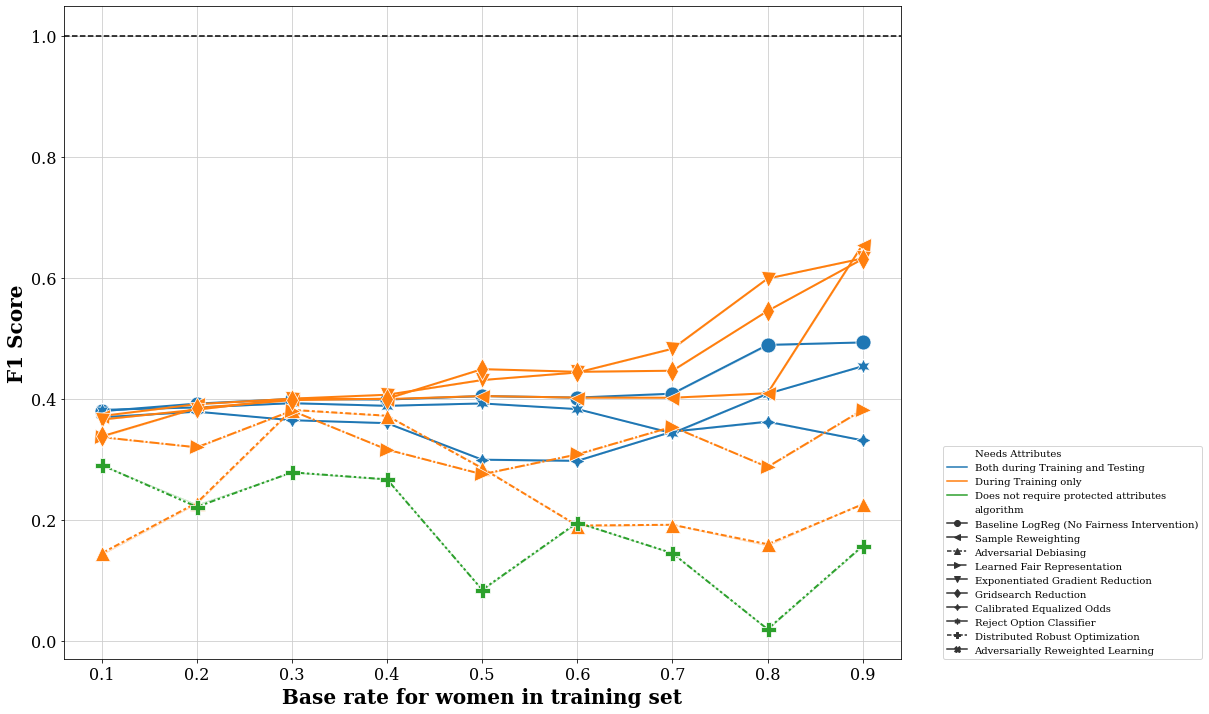

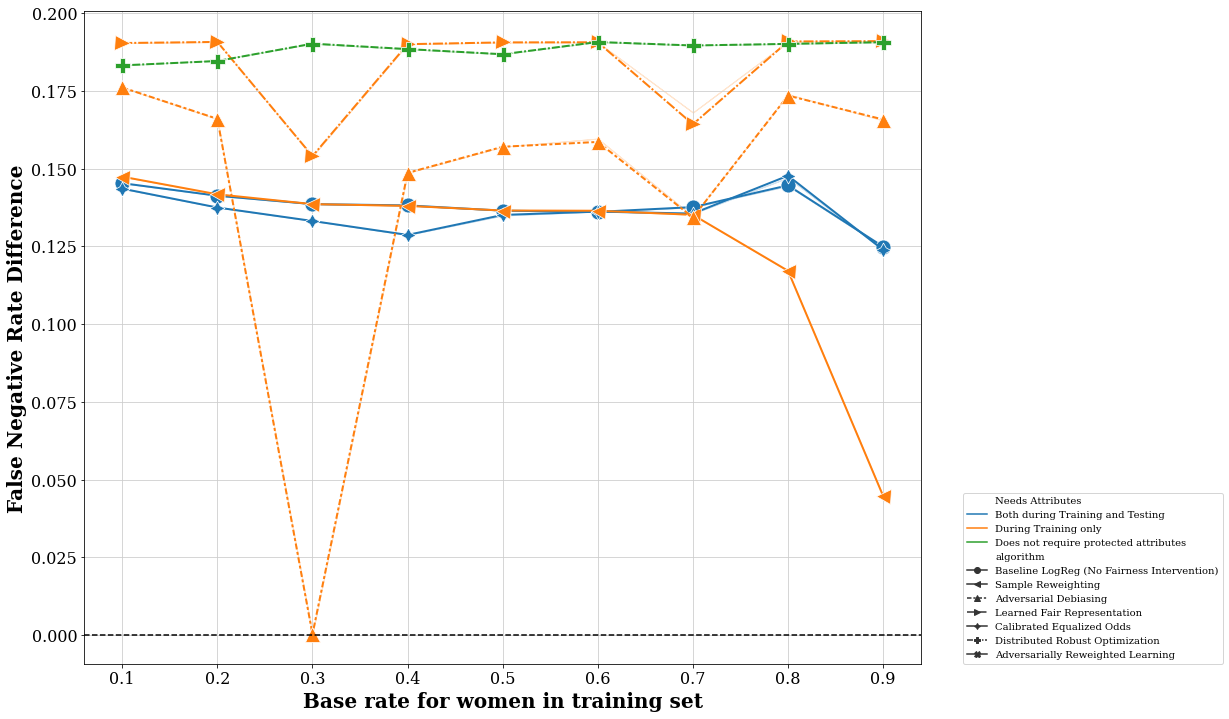

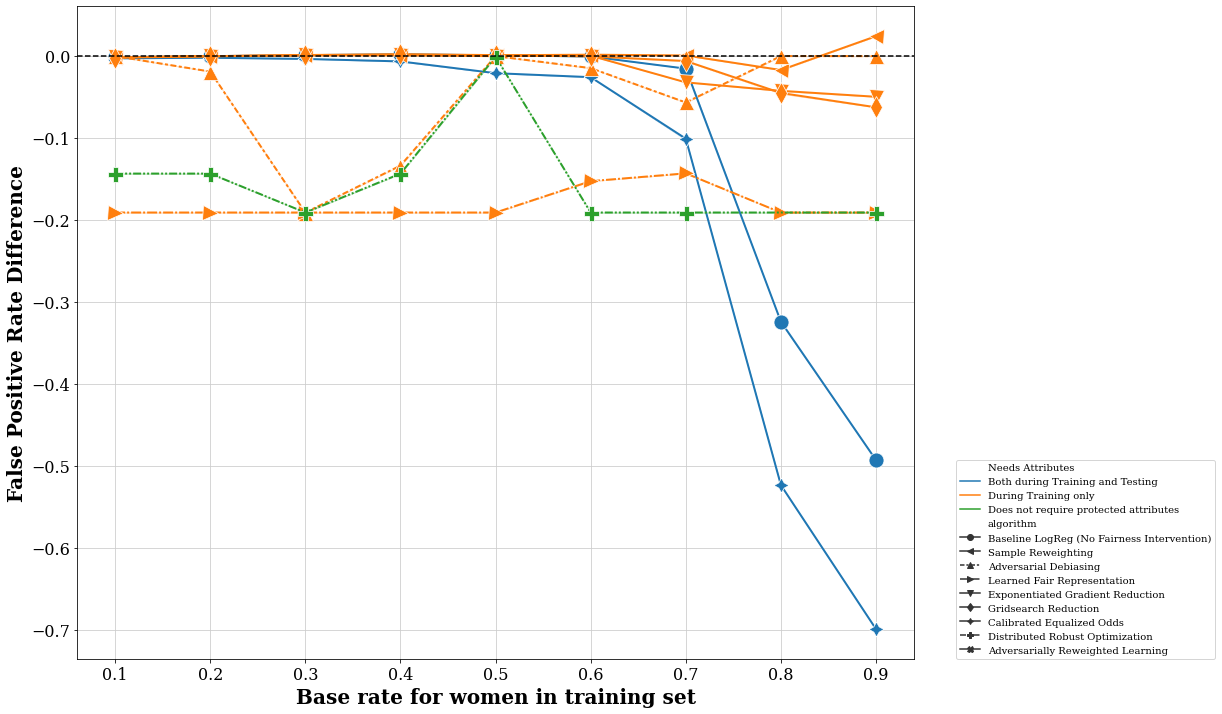

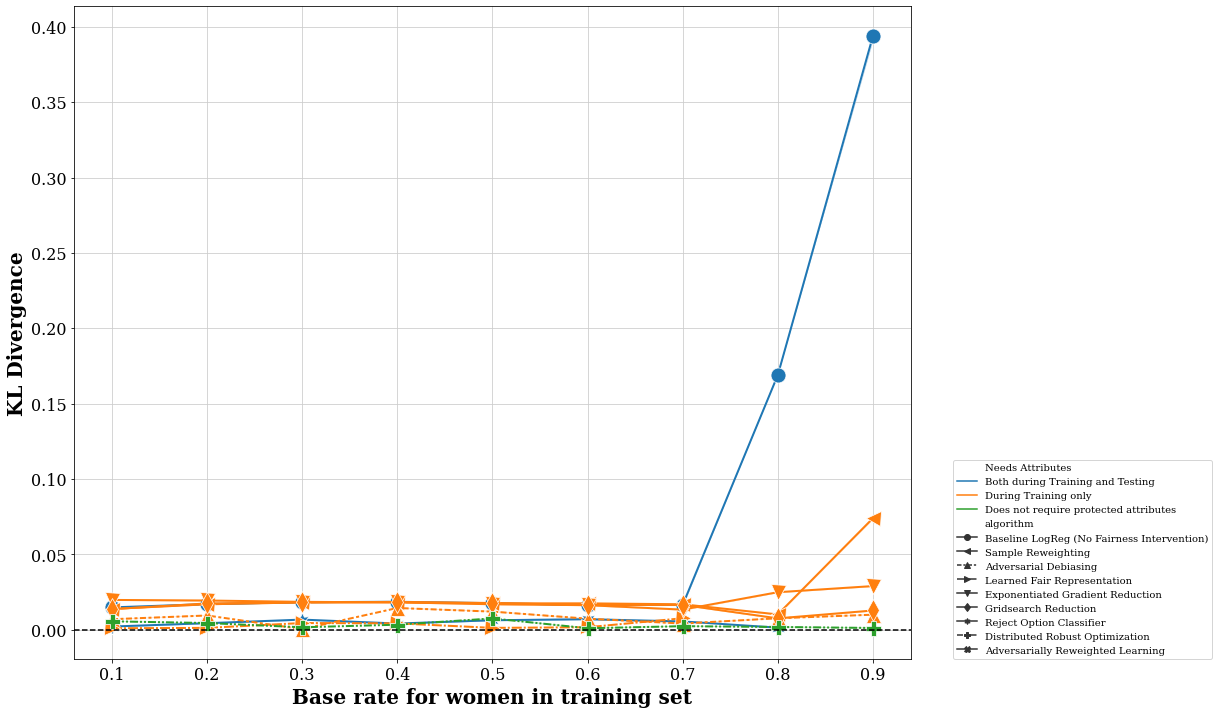

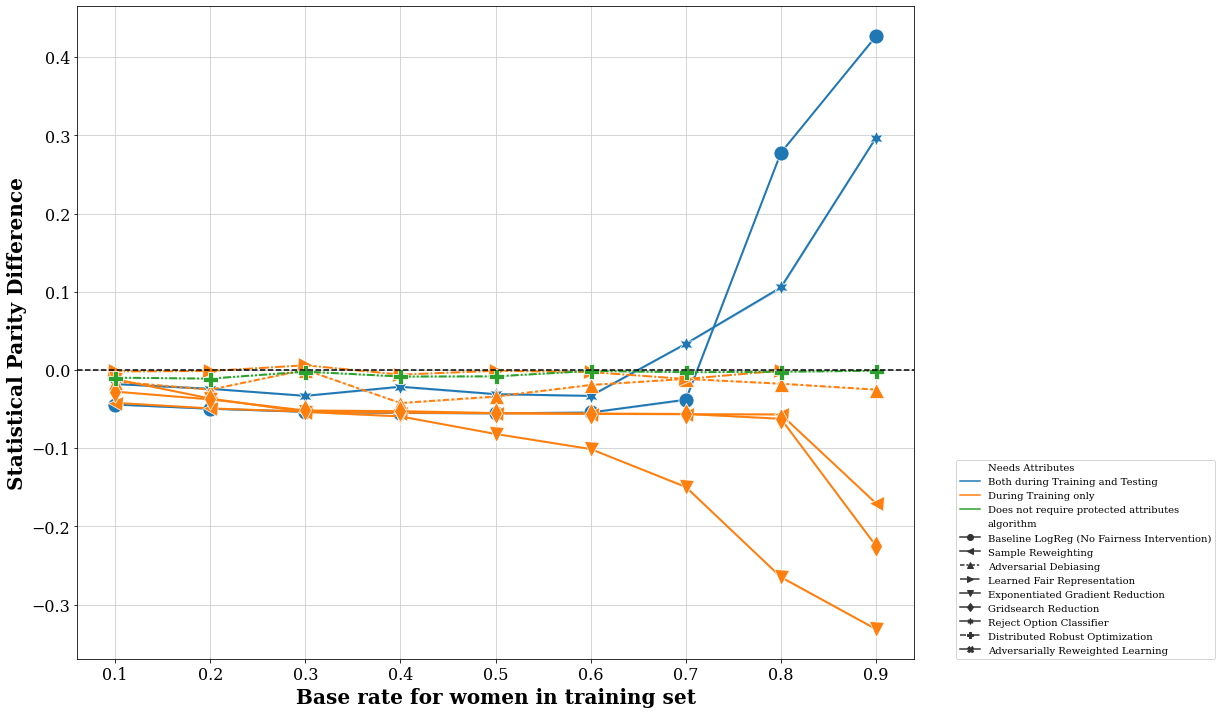

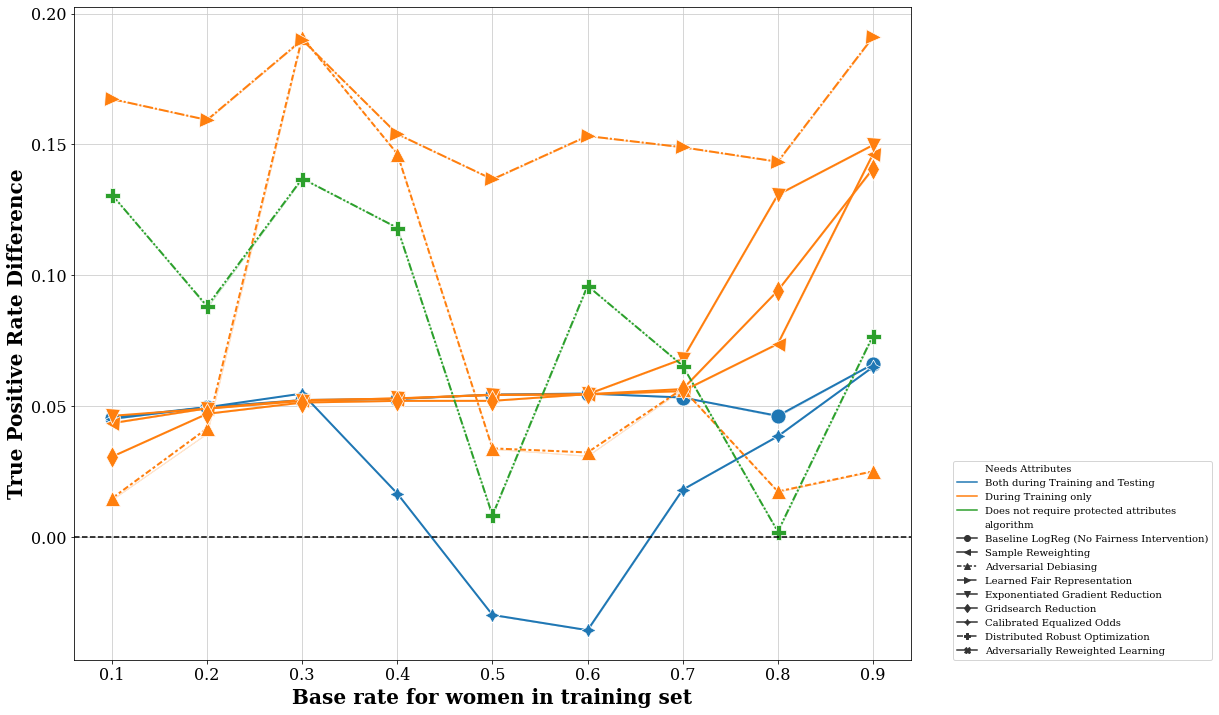

In [258]:
mpl.rcParams['figure.figsize'] = (15, 12)
plt.rcParams["font.family"] = 'DejaVu Serif'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42
algs = set(groupsizedf['algorithm'])
for group,df_group in baseratedf.groupby('metric'):
    df_group = df_group.reset_index(drop=True)
    sdic = get_stability(df_group)
    inc = []
    for alg in sdic:
        if conv(sdic[alg])>.92:
            inc.append(alg)
    for a in algs:
        if a not in sdic:
            inc.append(a)
#     for s in sdic:
#         print(s,sdic[s],conv(sdic[s]))
    dash_list = sns._core.unique_dashes(df_group['algorithm'].unique().size+1)
    style = {key:value for key,value in zip(df_group['algorithm'].unique(), dash_list[1:])}
    for i in inc:
        style[i]=''
    
    
    ax = sns.lineplot(data=df_group, x="percentage", y="value", hue="Needs Attributes", style="algorithm", markers=mstyle, dashes=style, ci = 0, linewidth = 2, markersize=15) #dashes=style
#     plt.title(group)

    if group in ['F1 Score', 'Accuracy']:
        plt.axhline(y=1,linestyle ='--', color='black')
    else:
        plt.axhline(y=0,linestyle ='--', color = 'black')
        
    plt.legend(loc=(1.05, 0))
    plt.xlabel("Base rate for women in training set",fontsize=20,weight='bold')
    plt.ylabel(group,fontsize=20,weight='bold')
    
    ax.xaxis.grid(True,which='both')
    ax.yaxis.grid(True,which='both')


    ax.set_facecolor('white')
    ax.tick_params(axis='y', which='both',labelsize=16)
    ax.tick_params(axis='x', which='both',labelsize=16)
    
    plt.gca().yaxis.set_major_formatter(ScalarFormatter())
    plt.savefig('Plots/synthetic_baserate_'+group+'.pdf', pad_inches = 0,bbox_inches = "tight")
    plt.show()

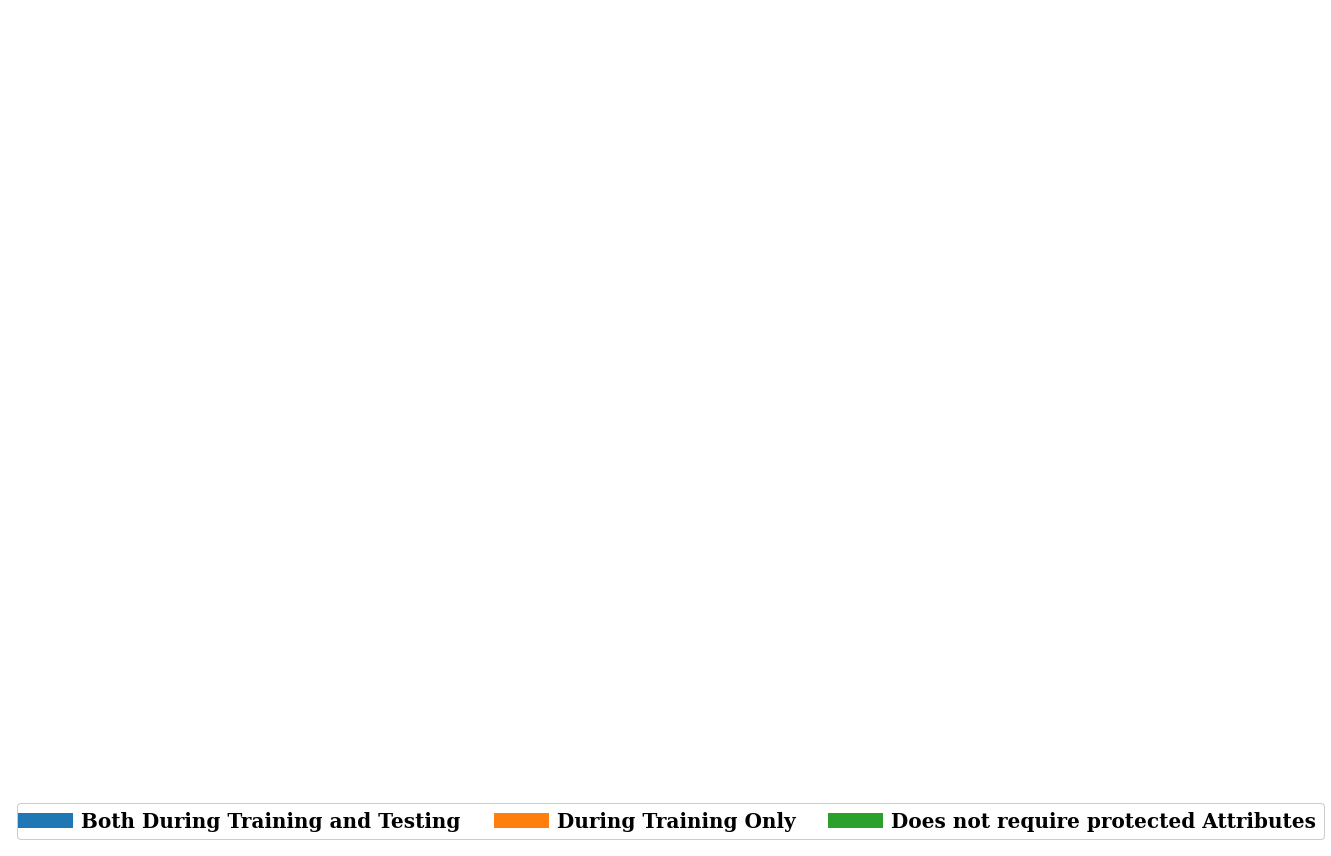

In [260]:
handles = []
colors = (0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (1.0, 0.4980392156862745, 0.054901960784313725), (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)
for cl in colors:
    handles.append(mpl.lines.Line2D(xdata=[],ydata=[],color=cl,linewidth=15))

labels = ['Both During Training and Testing', 'During Training Only', 'Does not require protected Attributes']
# labels.extend(mstyle.keys())
ax.clear()
plt.clf()
plt.cla()
plt.close()

legend = plt.legend(handles, labels, loc=3, framealpha=1, 
                    frameon=True,ncol=3,facecolor='white', prop = {'weight':'bold', 'size': 20})
plt.setp(legend.get_title(),fontsize=20)
plt.gca().set_axis_off()
plt.gca().set_facecolor('white')

plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
    hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

fig  = legend.figure
expand=[-5,-5,5,5]
fig.canvas.draw()
plt.tight_layout()
bbox  = legend.get_window_extent()
bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
plt.savefig('Plots/legend1.pdf', bbox_inches = "tight",pad_inches = 0)

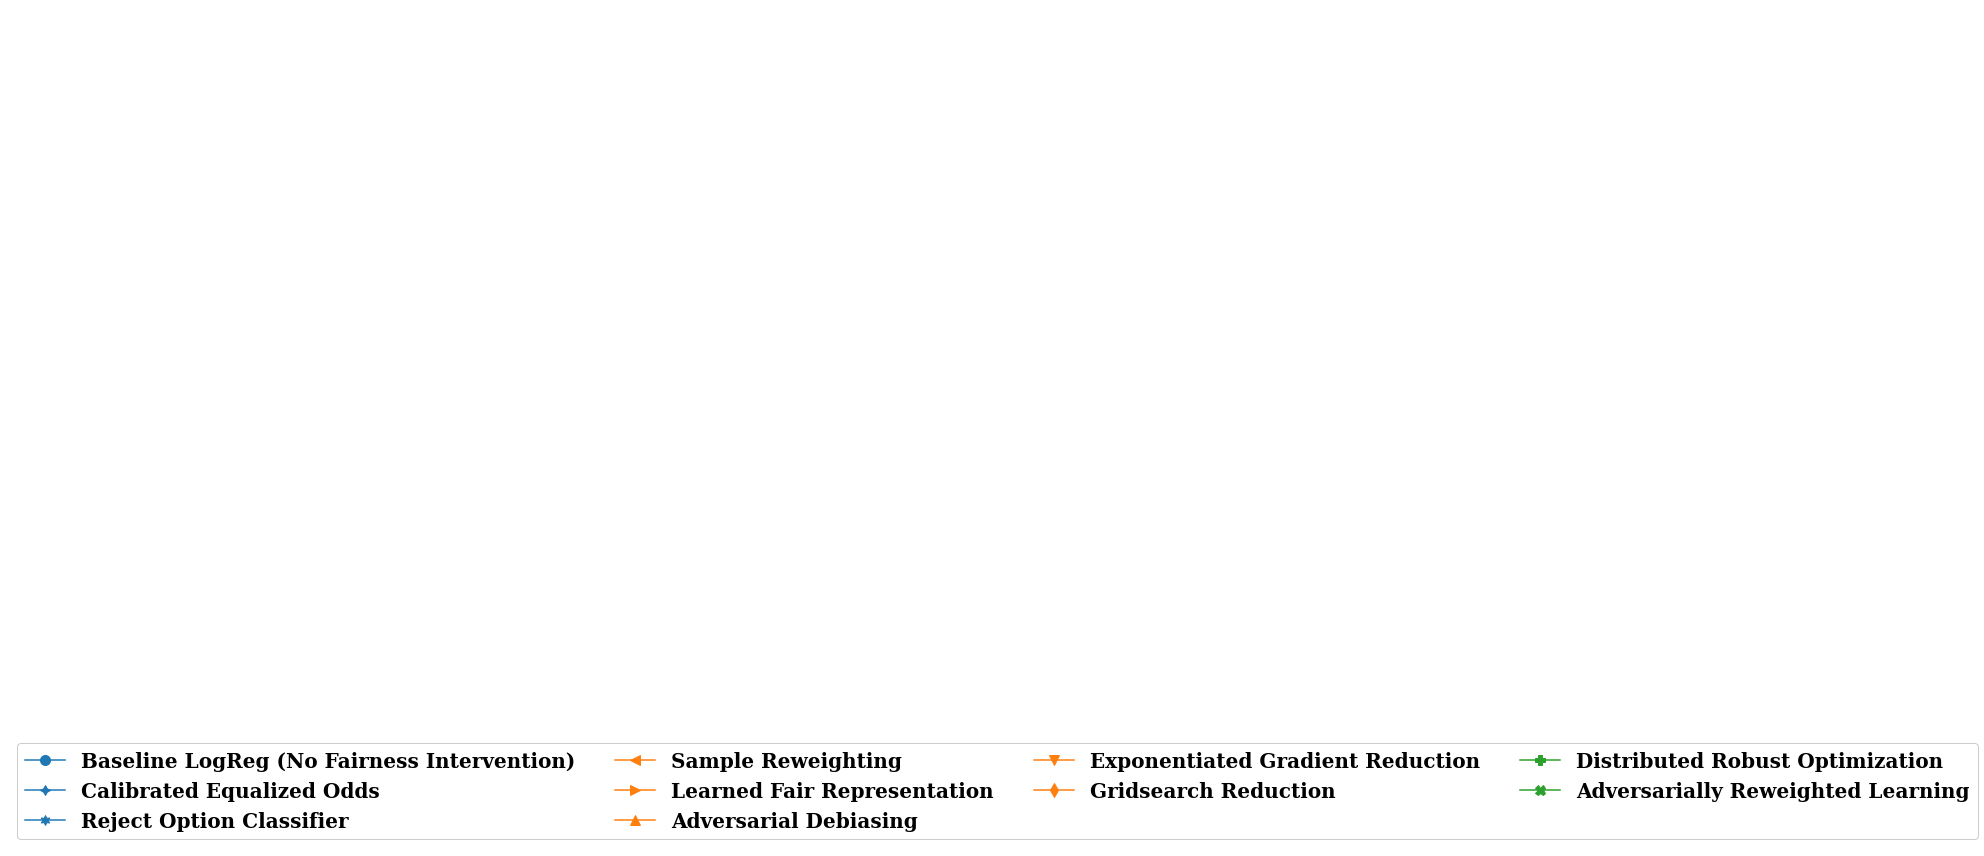

In [263]:
handles = []
colors = (0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (1.0, 0.4980392156862745, 0.054901960784313725), (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)
labels = list(mstyle.keys())
mcols = [colors[0],colors[0],colors[0],colors[1],colors[1],colors[1],colors[1],colors[1],colors[2],colors[2]]
for m,cl in zip(labels,mcols):
    handles.append(mpl.lines.Line2D(xdata=[],ydata=[],color=cl,marker=mstyle[m],markersize=10))

# labels.extend(mstyle.keys())
ax.clear()
plt.clf()
plt.cla()
plt.close()

legend = plt.legend(handles, labels, loc=3, framealpha=1, 
                    frameon=True,ncol=4,facecolor='white', prop = {'weight':'bold', 'size': 20})
plt.setp(legend.get_title(),fontsize=20)
plt.gca().set_axis_off()
plt.gca().set_facecolor('white')

plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
    hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

fig  = legend.figure
expand=[-5,-5,5,5]
fig.canvas.draw()
plt.tight_layout()
bbox  = legend.get_window_extent()
bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
plt.savefig('Plots/legend2.pdf', bbox_inches = "tight",pad_inches = 0)

In [291]:
list(mstyle.keys())

['Baseline LogReg (No Fairness Intervention)',
 'Calibrated Equalized Odds',
 'Reject Option Classifier',
 'Sample Reweighting',
 'Learned Fair Representation',
 'Adversarial Debiasing',
 'Exponentiated Gradient Reduction',
 'Gridsearch Reduction',
 'Distributed Robust Optimization',
 'Adversarially Reweighted Learning']